In [6]:
'''
Modify: 
Improve Segementation method:
- Green-Red-Nir -->Normalize Red-Nir-NDVI
- Finding the best segmentation
- Adding the multispectral image processing
- Choosing Direction 0 (small to big)
- Why synopses having only sort-terms instead of full-scale valdaition area
-> Bc of the BB weight threshold in evolution graph (done)
- Building pipelines for automatical images generation
- Back up for The end of phase 2 (The model is being modifed with changing the BB formation constrain)
- Strategy Selection: 
Date: 07/06/2023
'''

'\nModify: \nImprove Segementation method:\n- Green-Red-Nir -->Normalize Red-Nir-NDVI\n- Finding the best segmentation\n- Adding the multispectral image processing\n- Choosing Direction 0 (small to big)\n- Why synopses having only sort-terms instead of full-scale valdaition area\n-> Bc of the BB weight threshold in evolution graph (done)\n- Building pipelines for automatical images generation\n- Back up for The end of phase 2 (The model is being modifed with changing the BB formation constrain)\n- Strategy Selection: \nDate: 07/06/2023\n'

In [7]:
import rasterio
import os, time, datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from dtw import *
from skimage.segmentation import felzenszwalb
from rasterio.features import shapes as rio_shapes
from shapely.geometry import shape
from shapely.geometry.multipolygon import MultiPolygon
import cv2
import math

from preprocess import data_extractor, resize_ndvi 
from utilefunc.get_band_order_GS2 import get_band_order_GS2
from utilefunc.resample import resample
from utilefunc.get_palette import get_palette
from evolution_graph import evolution_graph_to_synopsis
from construct_bb_set import construct_bb_set
from final_bb_constraint import final_bb_constraint


np.set_printoptions(threshold=30)
# %matplotlib widget
%matplotlib inline
# For checking only

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [8]:
## segmentation parameters 
scale=5        # controls the number of produced segments as well as their size. Higher scale means less and larger segments. 
sigma=0          # diameter of a Gaussian kernel, used for smoothing the image prior to segmentation.
min_size=5      # minimum size of the segment

## BB selection and graph construction parameters
alpha = 0.4
t1 = 0.1
t2 = 0
direction= 0  # 0 : from small to big; 1: from big to small

In [9]:
## general data informations
#fields_data_fpath = 'pinnote_anomaly_info/annotations_valid_dates_final.csv'
#fields_data = pd.read_csv(fields_data_fpath, sep=';', )   # a list of season field ids
#sfd_ids = fields_data['sfd_id'].unique()  # all season field ids to process

data_path = 'data_test/'  # path for image time series, each stocked in a file folder named with the sfd_id
#data_path = 'data_claim/'
# save paths
save_path_df = 'variables_2023/raster_df/scale_{0}/'.format(scale)
if direction == 0:
    save_path_bb = 'variables_2023/BB_evolution_graph/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables_2023/sfd_bbs_cover/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
if direction == 1:
    save_path_bb = 'variables_2023/BB_evolution_graph/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables_2023/sfd_bbs_cover/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)

# Save paths for Evolution processes


In [10]:
dataPath = 'CSV_Data/'
#file = 'FieldData.csv'
#file = 'Non_Claim_Drought.csv'
#file = 'SoyExRains.csv'
#file = 'SoyExRain_Non.csv'
file =  'Non_Claim_Drought_1.csv'
data = pd.read_csv(dataPath+file, sep=';')
data = pd.DataFrame(data)
#data = gpd.GeoDataFrame(data, crs="EPSG:4326",geometry='geometry')

#'''
usecols = ['sfd_id','WKT']
rename = {
            'WKT': 'geometry',
            'sfd_id': 'Sfd_id'
}

data = data[usecols]
data.rename(columns=rename, inplace=True)
#'''
data

,Sfd_id,geometry
0,104849953,"MULTIPOLYGON (((-54.21227392 -24.73877752,-54...."
1,104863690,"MULTIPOLYGON (((-54.19266229 -24.74078992,-54...."
2,104852444,"MULTIPOLYGON (((-54.26514534 -24.71426675,-54...."
3,104843446,"MULTIPOLYGON (((-54.20499993 -24.69063554,-54...."
4,104844935,"MULTIPOLYGON (((-54.11866702 -24.5013416,-54.1..."
5,104841590,"MULTIPOLYGON (((-54.12024158 -24.49963808,-54...."
6,104846415,"MULTIPOLYGON (((-54.10067141 -24.49869377,-54...."
7,104844403,"MULTIPOLYGON (((-54.11835545 -24.51533248,-54...."
8,104855954,"MULTIPOLYGON (((-54.13982212 -24.51754537,-54...."
9,104841902,"MULTIPOLYGON (((-54.26939627 -24.72735157,-54...."


In [11]:
# Take 1 seasonal fields 
#sfd_ids = np.array([102112829]) # sfd_ids
sfd_ids = data['Sfd_id'].unique() 
t1 = 0
#sfd_ids = np.array(sfd_ids[0:10])
'''
# Case 1
sfd_ids = np.array([sfd_ids[12]]) # select 1 field
savePath = 'ImageResults/104840260'
'''
'''
#Case 2: Soy_Drought
sfd_ids = np.array(sfd_ids[0:10])
#sfd_ids = np.array([sfd_ids[9]]) # select 1 field
savePath = 'ImageResults/SoyDrought'
'''
'''
#Case 3: Soy_Drought - NOn
#sfd_ids = np.array(sfd_ids[:])
sfd_ids = np.array([sfd_ids[2]]) # select 1 field
savePath = 'ImageResults/SoyDrought_Non'
'''
'''
#Case 4: Soy_Ex - 
sfd_ids = np.array(sfd_ids[:])
savePath = 'ImageResults/SoyExRain'
'''
# Case 5: Normal Field in Drought one areas
sfd_ids = np.array(sfd_ids[:])
savePath = 'ImageResults/NormalFieldInArea'

sfd_ids

array([104849953, 104863690, 104852444, 104843446, 104844935, 104841590,
       104846415, 104844403, 104855954, 104841902], dtype=int64)

# Function

In [12]:
def data_extractor(data_path, sfd_id_choice, year_choice):
    """
    Extract and save file names for band image tif, band image gil and ndvi image tif 
    of a given field after filtering repeated images
    
    Parameters
    ----------
    data_path : string
        relative path for the images files
    sfd_id_choice : int or string
        season field id
    year_choice : int or string
        year. example : 2020
        
    Returns
    -------
    band_gil_file : string list
        list with all band image .gil file names
    band_tif_file : string list
        list with all band image .tif file names
    ndvi_tif_file : string list
        list with all ndvi image .tif file names
    """
    all_names = os.listdir(data_path + str(sfd_id_choice) + '/')
    image_names = [el for el in all_names if el.split('_')[2][:4] == str(year_choice)]
    image_names = sorted(image_names)
    
    band_tif_file= ['None']
    band_gil_file= ['None']
    ndvi_tif_file= ['None']
    # Problem 1 : There exist many images from the same satellite sensor and acquired for the same date, like : 
    # 103611228_Ndvi_20210526_Landsat8_Clear_13  103611228_Ndvi_20210526_Landsat8_Clear_14
    # we save the first one
    for img in image_names:
        if img.split('_')[1] == 'Ndvi' and img.split('_Clear_')[0] != ndvi_tif_file[-1].split('_Clear_')[0]:
            ndvi_tif_file.append(img)
        elif img.split('_')[1] == 'Bands' and img.endswith('.tif') and img.split('_Clear_')[0] != band_tif_file[-1].split('_Clear_')[0]:
            band_tif_file.append(img)
    #     elif img.split('_')[1] == 'Bands' and img.endswith('.gil') and img.split('_Clear_')[0] != band_gil_file[-1].split('_Clear_')[0]:
    #         band_gil_file.append(img)
    # band_gil_file.pop(0)
    band_tif_file.pop(0)
    ndvi_tif_file.pop(0)
    
    # Problem 2 : many images of the same date but from different satellites :
    # '104196913_Bands_20210429_Landsat8_Clear_11.gil',  '104196913_Bands_20210429_Sentinel2_Clear_12.gil'
    # we choose Sentinel2 according to the priority
    
    todelete = []
    '''
    for i in range(1, len(band_gil_file)):
        if band_gil_file[i-1].split('_')[2] == band_gil_file[i].split('_')[2]:
            if band_gil_file[i-1].split('_')[3] != 'Sentinel2':
                todelete.append(i-1)
            elif band_gil_file[i].split('_')[3] != 'Sentinel2':
                todelete.append(i)                
    '''
    for i in range(1, len(band_tif_file)):
        if band_tif_file[i-1].split('_')[2] == band_tif_file[i].split('_')[2]:
            if band_tif_file[i-1].split('_')[3] != 'Sentinel2':
                todelete.append(i-1)
            elif band_tif_file[i].split('_')[3] != 'Sentinel2':
                todelete.append(i) 
    #band_gil_file = np.delete(band_gil_file, todelete, 0)
    
    band_tif_file = np.delete(band_tif_file, todelete, 0)
    ndvi_tif_file = np.delete(ndvi_tif_file, todelete, 0)
    
    return band_gil_file, band_tif_file, ndvi_tif_file
def resize_ndvi(data_path, ndvi_tif_file, sfd_id_choice):
    """
    Preparation for ndvi image resizing
    
    Parameters
    ----------
    data_path : string
        relative path for the images files
    ndvi_tif_file : string list
        list with all ndvi image .tif file names
    sfd_id_choice : int or string
        season field id

    Returns
    -------
    mask_dict : dictionary
        dictionary with the key for season field id and the value for an numpy masked array
        this numpy masked array is of the standard size for next step, all unmasked values are 1
        the key is the season field id
    tif_info : dictionary
        this dictionary saves the EPSG and geotransform information of the .TIF file that corresponds
        to the standard image size
        the keys are 'EPSG' and 'transform'
    """
    # finding the most frequent size of NDVI images, consider it as the standard size
    h_w = [] # height-width
    for i in range(len(ndvi_tif_file)):
        img_ndvi_tif = data_path + str(sfd_id_choice) + '/' + ndvi_tif_file[i]  
        raster_ndvi = rasterio.open(img_ndvi_tif)
        h_w.append((raster_ndvi.height, raster_ndvi.width))
    h_w_norm = max(set(h_w), key=h_w.count)  # most frequent size

    # Create mask for the field : 
    mask_dict = dict()
    tif_info = dict()
    i=0
    while i < len(ndvi_tif_file) and i != -99:  # search for a standard size NDVI image
        img_ndvi_tif = data_path + str(sfd_id_choice) + '/' + ndvi_tif_file[i]  
        raster_ndvi = rasterio.open(img_ndvi_tif)
    
        if raster_ndvi.shape == h_w_norm:
            tif_info['EPSG'] = raster_ndvi.crs.to_epsg()
            tif_info['transform'] = raster_ndvi.transform
            #mask = raster_ndvi.read(1, masked=True)
            ## Fix the reading nan value of rasterio
            mask = raster_ndvi.read(1)
            mask = np.nan_to_num(mask, nan = 0)
            mask = np.ma.masked_values(mask,0)
            mask.fill(1)
            mask_dict[sfd_id_choice] = mask  # values are replaced by 1, we need the standard image mask
            i = -99
        else :
            i=i+1
    
    return mask_dict, tif_info

import scipy.ndimage as nd
def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell
    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)
    Output: 
        Return a filled array. 
    """

    if invalid is None: invalid = np.isnan(data)
    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

def resample(raster_in, raster_ref): 
    ''' Rezie the raster corresponding to the raster_ref'''
    ### Modified
    ModifiedInput = raster_in.astype(np.float32)
    raster_in_resampled = cv2.resize(fill(ModifiedInput.filled(np.nan)), dsize=raster_ref.shape[::-1], interpolation=cv2.INTER_CUBIC)
    ### Modified
    raster_in_resampled = np.ma.array(raster_in_resampled, mask=raster_ref.mask)
    return raster_in_resampled

def show_image(data, cmap=None):
    '''Show image '''
    plt.close('all')
    plt.imshow(data, cmap=cmap)
    plt.show()

def normalize(array):
    '''Normalize numpy arrays into scale 0-255 '''
    array_min, array_max = array.min(), array.max()
    return (((array-array_min)/(array_max-array_min))*255)

def ims(sfd_id_choice,segments_test,Position_image,bouding_box_segment,save=False):
    '''Displaying the segementation coresponding to the bounding_box_segment '''
    seg_image = segments_test[Position_image] # 68x67
    #bouding_box_segment = 7
    mask =np.zeros(seg_image.shape, dtype=np.uint8)
    mask[seg_image == bouding_box_segment] = 1
    clipped_image = np.ma.masked_values(cv2.bitwise_and(seg_image, seg_image, mask=mask),0)    
    plt.close('all')
    plt.imshow(clipped_image)
    plt.title(f'{sfd_id_choice}_{Position_image}_{bouding_box_segment}')
    if save:
        if not os.path.exists(f'{savePath}/BB/{sfd_id_choice}/'):
            os.makedirs( f'{savePath}/BB/{sfd_id_choice}/')
        plt.savefig(f'{savePath}/BB/{sfd_id_choice}/{Position_image}_{bouding_box_segment}.png ',format='png')        
    plt.close()

######## Eliminate invalid NDVI images
def RasterReading_MaskingNan(file):
    ndvi_raster_band  = rasterio.open(file)
    ndvi_image = ndvi_raster_band.read(1)        
    ndvi_image = np.nan_to_num(ndvi_image, nan = 0)
    ndvi_image = np.ma.masked_values(ndvi_image,0)
    return ndvi_image

def StandardSize(data_path,fileList):
    '''
    Return standard size of NDVI image
    StandardSize(data_path,ndvi_tif_file)
    '''
    ListAP = []
    for idx,img in enumerate(fileList):
        sfd_id = img.split('_')[0]        
        file = data_path + sfd_id +'/' + fileList[idx]        
        ndvi_image = RasterReading_MaskingNan(file)
        availabel_pixel = ndvi_image.size - ndvi_image.mask[ndvi_image.mask == True].sum()        
        ListAP.append(availabel_pixel)
    return np.max(np.unique(ListAP, return_counts=True))

def EliminateNonStandardSize(data_path, fileList):
    '''
    Keep only the standard size of NDVI images
    EliminateNonStandardSize(data_path, ndvi_tif_file)
    '''
    to_delete = []
    Std_Size = StandardSize(data_path,fileList)
    for idx,img in enumerate(fileList):
        sfd_id = img.split('_')[0]        
        file = data_path + sfd_id +'/' + fileList[idx]        
        ndvi_image = RasterReading_MaskingNan(file)
        availabel_pixel = ndvi_image.size - ndvi_image.mask[ndvi_image.mask == True].sum()
        
        if availabel_pixel <= 0.9*Std_Size:            
            to_delete.append(idx)
            
    ndvi_tif_file = np.delete(fileList,to_delete, axis=0)
    return ndvi_tif_file

############ Keep band_tif_file which consistent to ndvi_tif_file
def CorrespondingProcessing(ndvi_tif_file, band_tif_file):     
    '''
    # Eliminate the band images without having the corresponding ndvi images  
    CorrespondingProcessing(ndvi_tif_file,band_tif_file)
    '''
    keep = []
    for i in range(len(ndvi_tif_file)):
        for j in range(len(band_tif_file)):
            if ndvi_tif_file[i].split('_')[2] == band_tif_file[j].split('_')[2]:
                keep.append(band_tif_file[j])
    return np.array(keep)

def KeepOnlyJanuary(ndvi_tif_file):
    to_delete = []
    for idx,img in enumerate(ndvi_tif_file): 
        if ndvi_tif_file[idx].split('_')[2][:4] == '2022' and ndvi_tif_file[idx].split('_')[2][4:6] != '01':
            to_delete.append(idx)
    return np.delete(ndvi_tif_file, to_delete, axis=0)

def CummulativeBB_proportion(data):
    '''
    # Cummulative all the BB_porportion
    '''
    b = data.sum()
    '''
    if b > 90 :
        b = data.max()    
    '''
    return b

### Generate the img_ndvi_tif
def Generate_Segmentation_Image(segments_test,savePath,DATE,sfd_id,save=False):     
    NoImage = len(segments_test)
    ncols = 4    
    NoRows = int(math.ceil(NoImage/ncols))
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(15,8) )    
    for idx,img in enumerate(segments_test):        
        #cmap, norm = get_palette(ndvi_image)
        row,col = idx//ncols, idx%ncols        
        ax[row][col].set_title(f'{DATE[idx]}')
        a = ax[row][col].imshow(
            img,
            #cmap='RdYlGn',
        )        
        ax[row][col].axis('off')        
        # Set the colorbar scale
        #a.set_clim(vmin=0, vmax=1)
        
    #fig.colorbar(a, ax=ax[:,:])
    fig.suptitle(f'Segmentation Images of {sfd_id} from {DATE[0]} to {DATE[-1]}')    
    if save:
        if not os.path.exists(f'{savePath}/Segmentation'):
            os.makedirs( f'{savePath}/Segmentation')
        fig.savefig(f'{savePath}/Segmentation/{sfd_id}.png ',format='png')        
    
    #plt.show()    

### Generate the img_ndvi_tif
def Generate_NDVI_Image(data_path,fileList, savePath, save=False): 
    ''' Generate the set of NDVI images '''       
    NDVI_numpy = []
    DATE = []    
    NoImage = len(fileList)
    ncols = 4    
    NoRows = int(math.ceil(NoImage/ncols))
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(25,10) )    
    for idx,img in enumerate(fileList):
        sfd_id = img.split('_')[0]
        Date = img.split('_')[2]
        file = data_path + sfd_id +'/' + fileList[idx]
        ndvi_raster_band  = rasterio.open(file)
        ndvi_image = ndvi_raster_band.read(1)
        mean = np.nanmean(ndvi_image)
        ndvi_image = np.nan_to_num(ndvi_image, nan = 0)        
        ndvi_image = np.ma.masked_values(ndvi_image,0)               
        NDVI_numpy.append(ndvi_image)
        DATE.append(Date)
        #cmap, norm = get_palette(ndvi_image)
        row,col = idx//ncols, idx%ncols        
        ax[row][col].set_title(f'{Date}-NDVI_mean: {mean:.2f}')
        a = ax[row][col].imshow(
            ndvi_image,
            cmap='RdYlGn',
        )        
        ax[row][col].axis('off')
        #plt.colorbar(a)
        # Set the colorbar scale
        a.set_clim(vmin=0, vmax=1)
        
    fig.colorbar(a, ax=ax[:,:])
    fig.suptitle(f'Field ID:{sfd_id} from {DATE[0]} to {DATE[-1]}')        
    if save:
        if not os.path.exists(f'{savePath}/NDVI'):
            os.makedirs( f'{savePath}/NDVI/')
        plt.savefig(f'{savePath}/NDVI/{sfd_id}.png ',format='png')        
    
    #plt.show()
    return NDVI_numpy, DATE, sfd_id

def SynopsisGraph(sfd_id,all_synopsis_list,all_date_list,year_choice,label_color=True,cluster_color=True,save=False):
    ''' Draw the Synopsis Graph'''
    _, ax1 = plt.subplots(figsize=(12,6))
    ax1.grid(True)
    ax1.set_ylim(0,1)
    for i in range(len(all_synopsis_list)):
        if type(label_color) != bool:
            ax1.plot(all_date_list[i], all_synopsis_list[i], color=label_color[str(i)])
        else:
            ax1.plot(all_date_list[i], all_synopsis_list[i])
    if type(cluster_color) != bool:
        legend_element = [plt.Line2D([0], [0], color=c, linestyle='-') for c in cluster_color.keys()]
        legend_label = [i for i in cluster_color.keys()]
        ax1.legend(legend_element, legend_label,loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))    
    # ax1.legend(legend_element, legend_label, bbox_to_anchor=(0.75, 0.7), bbox_transform=plt.gcf().transFigure)
    plt.title(f"Clustering results of the synopsis vectors of evolution graphs of all fields in {year_choice}-{year_choice+1}")
    if save:
        if not os.path.exists(f'{savePath}/Synopsis/'):
            os.makedirs( f'{savePath}/Synopsis/')
        plt.savefig(f'{savePath}/Synopsis/{sfd_id}.png ',format='png') 
    #plt.show()

def helps(uni_dates,year_choice):
    ''' Yield the sorted DataFrame including year+1, is suitable for the new dataset'''
    timeStamp_List = []
    for i in range(len(uni_dates)):        
        timeStamp = pd.to_datetime(uni_dates[i]-1,unit='D',origin=str(year_choice))
        b = timeStamp.month_name()
        if b =='January' or b =='February':
            timeStamp = pd.to_datetime(uni_dates[i]-1,unit='D',origin=str(year_choice+1))
        timeStamp_List.append(timeStamp)

    result = pd.DataFrame(timeStamp_List, columns=['date'] )
    result = result.sort_values(by='date', ascending=True,)
    return result

def dtw_normalized_dist(a, b):
    # find dates where both of the two time series have data
    common = ~np.isnan(a) & ~np.isnan(b)
    a_c = a[common]
    b_c = b[common]
    if a_c.size == 0 or b_c.size == 0: # if one of them is empty, it means they have non dates in common
        distance = 1   #10
    else:
        # delete NANs in the beginning and the end of the time series
        a = a[~np.isnan(a)]
        b = b[~np.isnan(b)]
        alignment = dtw(a, b, keep_internals=True)
        distance = alignment.normalizedDistance  # normalised by the sum of lengths of the two series
    return distance

def get_cluster_color(dendrogram):
    '''
    Return:
    The class of dendogram - This case (C0,'#ff0029')
    d['icoord']  - These coordinates determine the starting and ending points of each line segment in the dendrogram plot
    d['ivl'] - A list of labels corresponding to the leaf nodes
    d['color_list'] - list of color
    '''
    cluster_idxs = dict()
    for c, pi in zip(dendrogram['color_list'], dendrogram['icoord']):
        l = []
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                l.append(int(i)) # unuse
        cluster_idxs[c] = cluster_idxs.get(c, []) + l
    cluster_classes = dict()
    for c, l in cluster_idxs.items():
        i_l = [dendrogram['ivl'][i] for i in l]
        cluster_classes[c] = np.unique(i_l)
    return cluster_classes

def plotInertialGraph(sfd_id,x,inter,save=False):
    '''
    Plot Intertial Graph
    x: threshold
    inter: inertia
    plotInertialGraph(sfd_id,x,inter,save=True)
    '''
    fig = plt.figure(figsize=(10,7))
    plt.grid(True)
    ax1 = fig.add_subplot(111)    
    #ax2 = ax1.twinx()
    # ax2.plot(x, num_cluster, '--g', label='Nombre de clusters')
    # ax2.set_ylabel('Nombre de clusters')    
    ax1.plot(x, inter, label='Inertie inter-cluster')
    ax1.set_ylabel('Inertie')
    #ax1.errorbar(x, intra_mean, yerr=intra_std, fmt='--.r', ecolor='grey', elinewidth=2, capsize=2, label='Inertie intra cluster')
    #ax1.plot(x, intra_std, '--o', label='Std intra cluster')
    #ax2.plot(x, [intra_mean[i]/inter[i] for i in range(len(x))], '--r', label='Ratio intra/inter')
    #ax2.set_ylabel('Ratio intra/inter')
    lines, labels = ax1.get_legend_handles_labels()
    #lines2, labels2 = ax2.get_legend_handles_labels()
    #ax2.legend(lines + lines2, labels + labels2, loc=0)
    #plt.axvline(x=0.025, c='b', lw=2, linestyle='dashed')
    plt.title(f'{sfd_id}')
    if save:
        if not os.path.exists(f'{savePath}/InertialGraph/'):
            os.makedirs( f'{savePath}/InertialGraph/')
        fig.savefig(f'{savePath}/InertialGraph/{sfd_id}.png ',format='png') 
    plt.close()


def InertiaValueOptimization(sfd_id,data_uniform_array,Z,n_synopsis):
    '''
    Finding the Optimal value Based on 
    result = InertiaValueOptimization(sfd_id,data_uniform_array,Z,n_synopsis)
    '''
    xthreshold = np.arange(0.1,0,-0.005)

    intra_std = []
    intra_mean = []
    inter = []
    num_cluster = []
    x = []
    plt.figure()
    for threshold in xthreshold:
        d = dendrogram(Z, orientation='right', truncate_mode='level', p=n_synopsis, color_threshold=threshold, above_threshold_color='grey')

        cluster_color = get_cluster_color(d)
        if len(cluster_color.keys())>50:
            break
        else:
            centers = []
            # inertie intra cluster - among clusters
            intra_k = []
            for idx, (k, v) in enumerate(cluster_color.items()):
                l = [int(i) for i in v] # list the cluster same colors Ex- in grey

                if len(l) != 0:
                    center = np.nanmean(data_uniform_array[l, :], axis=0)# calculate all the mean of n_sunpsis of each day
                    centers.append(center) # (**,19) aaray - ** depend on the field

                    inertie_intra = 0
                    for j in l:
                        # Cumulative the normalized distance dtw between center and each date
                        inertie_intra += dtw_normalized_dist(data_uniform_array[j, :], center)**2 
                    inertie_intra = inertie_intra/len(l) # average cummulative Normalized between center and each date
                else:
                    continue
                intra_k.append(inertie_intra)
        #         print(f'inertie intra cluster : {k} - {inertie_intra}')

            intra_std.append(np.nanstd(intra_k))
            intra_mean.append(np.nanmean(intra_k))

            # inertie inter clusters - between clusters
            inertie_inter = 0
            c = np.nanmean(np.array(centers), axis=0)#  
            for center in centers:
                # Cummulative betwwen the Mean of ** abd 
                inertie_inter += dtw_normalized_dist(c, center)**2
                inertie_inter = inertie_inter/len(centers)
            inter.append(inertie_inter)
            num_cluster.append(len(centers))
    #     print(f'inertie inter cluster : {inertie_inter}')
            x.append(threshold)
    
    plt.close()
    plotInertialGraph(sfd_id,x,inter,save=True)
    ## Finding optimal value - the min value expect the 0
    uniqueInter = np.unique(inter)
    # 0 elimination
    if len(uniqueInter) == 1:
        optimalIndx = uniqueInter
        optimalVal = x[np.where(inter == optimalIndx)[0][0]] 
    else:
        optimalIndx = np.min(np.unique(uniqueInter[1:]))
        optimalVal = x[np.where(inter == optimalIndx)[0][0]]    
    
    return optimalVal


def AnomalyCluster(Z,n_synopsis,threshold,syn_label):
    '''
    Detect the anomaly cluster
    Return the PositionImage_BB
    result = AnomalyCluster(Z,n_synopsis,threshold,syn_label)
    
    '''
    plt.figure()
    d = dendrogram(Z,
               orientation='right', 
               truncate_mode='level', 
               p=n_synopsis, 
               color_threshold=threshold, 
               above_threshold_color='grey',
                )
    cluster_color = get_cluster_color(d)
    label_color = {label:k for k,v in cluster_color.items() for label in v}
    # If not grey --> Anomaly
    cluster_anomaly = {label:k for k,v in cluster_color.items() for label in v if k != 'grey'}
    # Anomaly cluster index
    listAnomalyIndex = list(cluster_anomaly.keys())
    AnomalyCluster = [syn_label[int(i)].split(':')[1] for i in listAnomalyIndex]
    plt.close('all')
    return AnomalyCluster, listAnomalyIndex

def AnomalyClusterCumPercentage(dataFrame, AnomalyCluster,column_id, column_proportion):
    '''
    Return the cummulative BB_proportion of AnomalyCluster
    BB_proportion
    re = AnomalyClusterCumPercentage(sfd_bb_geo_df,AnomalyCluster,'BB_id','BB_proportion')
    '''
    df = pd.DataFrame()
    for i in AnomalyCluster:
        a = dataFrame[dataFrame[column_id] == i]
        df = pd.concat([df,a])
    return df[column_proportion].sum()

def plotAnamoly(sfd_id,listAnomaly,all_date_list,all_synopsis_list,syn_label,save=False,all_cluster=False,show_plot=False):   
    '''
    listAnomaly : index of 
    Plot the anomaly cluster
    plotAnamoly(sfd_id,listAnomaly,all_date_list,all_synopsis_list,syn_label,save=True)
    '''
    plt.close('all')
    fig, axs = plt.subplots(nrows= len(listAnomaly),figsize= (8,15))
    for num,i in enumerate(listAnomaly):         
        idx = int(i)
        axs[num].plot(all_date_list[idx], all_synopsis_list[idx]) #color=label_color[str(idx)])        
        axs[num].set_title(f'Evolution graph synopsis of {syn_label[idx]}')
        axs[num].grid('True')
    if save:
        if all_cluster:
            if not os.path.exists(f'{savePath}/All_BB/'):
                os.makedirs( f'{savePath}/All_BB/')
            fig.savefig(f'{savePath}/All_BB/{sfd_id}.png ',format='png') 
        else: 
            if not os.path.exists(f'{savePath}/Anomaly/'):
                os.makedirs( f'{savePath}/Anomaly/')
            fig.savefig(f'{savePath}/Anomaly/{sfd_id}.png ',format='png') 
    if show_plot:
        plt.show()
    else:
        plt.close()   


In [13]:
'''
def DisplayingAllPixels(data):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)    
    return pd.DataFrame(data)  
'''

"\ndef DisplayingAllPixels(data):\n    pd.set_option('display.max_columns', None)\n    pd.set_option('display.max_rows', None)    \n    return pd.DataFrame(data)  \n"

In [14]:
def construct_bb_set(segments_test, alpha=0.2, direction=1, min_bb_size=40):
    """
    Construct a set of bounding boxs 
    
    Parameters
    ----------
    segments_test : Pandas series
        time series of numpy array for the segmentation results; 
        index: date like '2021-04-02'
        value: numpy array of the same size as band image, number corresponds to segment id
    alpha : float, optional
        constraint for the BB's novelty (weight). The default is 0.2.
    direction : bool, optional
        decide whether select bb from the biggest candidate to the smallest.
        The default is 1 (big -> small).
    min_bb_size : int, optional
        constraint for the BB's minimum number of pixels. The default is 40.

    Returns
    -------
    bb_final_list : a nx4 numpy array
        it stocks all necessary informations for the BBs
        n rows : n BBs
        4 columns : 
            1 - image position of a given BB:
            2 - corresponding segment ID in this image; 
            3 - number of pixels of a given BB;
            4 - weight of a given BB

    """
    ## Bounding Box (BB) selection
    # We create a list where we will write candidate BB
    bb_candidates_list = None
    
    # We open segmented images and construct candidates bb list. When all the segmented images are iterated we will start to calculate weights.
    # The list columns are Image_Id, Segm_Id, Segm_Size, Segm_Weight
    segm_array_list = []    # future stack of segmented images
    date_list = []  # image dates
    
    # We filter out only corresponding raster segmentation images. The list is sorted by date.
    image_name_segm_list = segments_test.index.values
    nbr_images = len(image_name_segm_list)
    
    # We iterate through segmentation images to make a stack of them
    for i in range(nbr_images):
        date = image_name_segm_list[i]
        # if i!= 0:
        #     image_name_segm_prev = image_name_segm_list[i - 1]
        #     date_prev = image_name_segm_list[i - 1] 
        # if i != len(image_name_segm_list)-1:
        #     image_name_segm2 = image_name_segm_list[i + 1]
        #     date2 = image_name_segm_list[i + 1] 
        date_list.append(date)
        
        image_array_seg = segments_test.iloc[i]
        (H, W) = image_array_seg.shape
        segm_array_list.append(image_array_seg)
    
        # We write all the segments to candidate BB list ([image_id, seg_id, seg_size, seg_weight=0])
    #     unique, count = np.unique(image_array_seg.flatten()[np.where(image_array_seg.flatten() != 0)[0]], return_counts=True)  # only change areas are segmented, no change areas have 0 id value.
        unique, count = np.unique(image_array_seg.flatten(), return_counts=True)
        candidates_bb_image = np.transpose([np.full(len(unique), i), unique, count, np.full(len(unique), None)])  # [image_id, seg_id, seg_size, seg_weight=0]
        if bb_candidates_list is None:
            bb_candidates_list = candidates_bb_image
        else:
            bb_candidates_list = np.concatenate((bb_candidates_list, candidates_bb_image), axis=0)
    bb_candidates_list = np.asarray(bb_candidates_list, dtype=object)
    
    # decide how to selection BBs from the candidate list
    if direction == 1:
        order = np.flip(bb_candidates_list[:, 2].argsort(), axis=0) # sort the candidate BB in descending order of size
    else:
        order = bb_candidates_list[:, 2].argsort()  # sort the candidate BB in ascending order of size
    bb_candidates_list = bb_candidates_list[order]

    # we create a grid that we will fill with bb. 0 - not covered grid, >=1 - covered grid (if >1, there is overlapping)
    covered_grid_flatten = np.zeros((H, W)).flatten()

    # We iterate through the list of candidate BB and we compute their novelty (weight)
    for c in range(len(bb_candidates_list)):
        candidate = bb_candidates_list[c]
        image, ind, size = candidate[:3]  # image_id, seg_id, seg_size
        if size > min_bb_size :#and size <= 0.5*H*W:   # we optionally set the minimum (and maximum) size for a BB  
            coverage_ind = np.where(segm_array_list[image].flatten()==ind)[0]   # we get pixel indicies of the segment
            novelty_pixels = covered_grid_flatten[coverage_ind] # we get values from covered grid to find out whether this footprint is already covered
            novelty_size = len(np.where(novelty_pixels == 0)[0])    # number of pixels that are not covered by any BB yet
            novelty = novelty_size/size     # novelty value
            # To better understand, read the article
            if novelty == 1:
                #bb_candidates_list[c, 3] = size # segment weight
                bb_candidates_list[c, 3] = novelty
                
                covered_grid_flatten[coverage_ind] += 1  # we fill the grid with covered pixels
            elif novelty >= alpha and novelty < 1:
                bb_candidates_list[c, 3] = novelty
                # we recompute the weight of other candidates as there is an intersection
                not_novelty_coverage_ind = np.intersect1d(coverage_ind, np.where(covered_grid_flatten >= 1)[0], assume_unique=True)  # overlapping pixel index
                covered_grid_flatten[coverage_ind] += 1  # we fill the grid with covered pixels
                for im in range(nbr_images):
                    if im != image:
                        image_array_seg_flatten = segm_array_list[im].flatten()
                        segments_to_modify = np.unique(image_array_seg_flatten[not_novelty_coverage_ind])
    
                        for s in segments_to_modify:
                        #   we check only BBs that have been already visited and we modify their weight --- :c
                            index_bb_to_modify = np.intersect1d(np.where(bb_candidates_list[:c, 0]==im)[0], np.where(bb_candidates_list[:c, 1]==s)[0])
                            if len(index_bb_to_modify) > 0:
                                index_bb_to_modify = index_bb_to_modify[0]
                                index_of_to_be_modified, size_of_to_be_modified = bb_candidates_list[index_bb_to_modify, 1:3]
                                coverage_ind_of_to_be_modified = np.where(image_array_seg_flatten == index_of_to_be_modified)[0]
                                if bb_candidates_list[index_bb_to_modify, 3] != 0:
                                    novelty_to_be_modified = len(np.where(covered_grid_flatten[coverage_ind_of_to_be_modified]==1)[0])/size_of_to_be_modified
                                    if novelty_to_be_modified >= alpha:
                                        bb_candidates_list[index_bb_to_modify, 3] = novelty_to_be_modified
                                        #print(f'novelty_to_be_modified {bb_candidates_list[index_bb_to_modify,0]}-{bb_candidates_list[index_bb_to_modify,1]}:{bb_candidates_list[index_bb_to_modify, 3]}')
                                    else:
                                        bb_candidates_list[index_bb_to_modify, 3] = 0
                                        covered_grid_flatten[coverage_ind_of_to_be_modified] -= 1  # as bb is not novel anymore, we take it off from the coverage grid
            else:
                bb_candidates_list[c, 3] = 0
        else:
            bb_candidates_list[c, 3] = 0

    
    
    # We sort candidates BBs by descending order
    bb_candidates_list_by_weight = np.copy(bb_candidates_list[np.flip(bb_candidates_list[:, 3].argsort(), axis=0)])
    # We create the final list with final BBs that have weight greater than alpha (in our case all weights < aplha correspond to 0)
    bb_final_list = bb_candidates_list_by_weight[bb_candidates_list_by_weight[:, 3] > 0]
    
    return bb_final_list


def final_bb_constraint(bb_final_list, segments_test, t1=0.4, t2=0):
    """
    Construct evolution graphs for each BB in the former selected set, it also eliminate BBs which are 
    less representatives
    
    Parameters
    ----------
    bb_final_list : a nx4 numpy array
        it stocks all necessary informations for the BBs
        n rows : n BBs
        4 columns : 
            1 - image position of a given BB:
            2 - corresponding segment ID in this image; 
            3 - number of pixels of a given BB;
            4 - novelty of a given BB
    segments_test : Pandas series
        time series of numpy array for the segmentation results; 
        index: date like '2021-04-02'
        value: numpy array of the same size as band image, number corresponds to segment id
    t1 : float, optional
        constraint the percentage of pixels of a segment inside the given BB 
        The default is 0.4.
    t2 : float, optional
        constraint the percentage of pixels of a BB inside the given segment
        The default is 0.

    Returns
    -------
    bb_final_list : a mx6 numpy array
        it stocks all necessary informations for the BBs as well as the attached segments (for evolution graph)
        m rows : m BBs finally choosen
        6 columns : 
            1 - image position of a given BB:
            2 - corresponding segment ID in this image; 
            3 - number of pixels of a given BB;
            4 - weight of a given BB;
            5 - N segments attached to the evolution graph of a given BB, 
                it is a Nx2 array where each column means (image_position, segment_ID) for each segment;
            6 - a Nx4 array where each column means, for each segment attached,  
                (image_position, segment_ID, % of pixels inside the given BB, the given BB's index in the (bb_final_list) 
    """
    # Constraint final BB
    t3 = 0#0.2    # tau3  # used in the paper, we don't use it 
    
    # try constructing graph by descending order of BB size
    bb_final_list = bb_final_list[np.flip(bb_final_list[:, 2].argsort(), axis=0)] 
    
    bb_final_list = np.c_[bb_final_list, np.full((len(bb_final_list), 2), None, dtype=object)]   # We add 2 empty columns
    
    # We open segmented images and construct candidates bb list.
    segm_array_list = []    # future stack of segmented images
    date_list = []  # image dates
    outliers_total_list = []
    outliers_total = None
    image_name_segm_list = segments_test.index.values
    nbr_images = len(image_name_segm_list)
    for i in range(nbr_images):
        date = image_name_segm_list[i]
        date_list.append(date)
        image_array_seg = segments_test.iloc[i]
        (H, W) = image_array_seg.shape
    
        segm_array_list.append(image_array_seg)
        outliers_array = np.zeros((H, W))
        
        if outliers_total is None:
            outliers_total = np.zeros((H, W))
        outliers_total += outliers_array
        
        outliers_total_list.append(outliers_array)
    
    # # #we create a grid
    covered_grids = np.copy(outliers_total_list) -1 # -1 not coverd grid, >=0 covered
    covered_grids_flatten = np.reshape(covered_grids, (nbr_images, H*W))  
    covered_grids_flatten_to_be_filled = np.copy(covered_grids_flatten)     # These grids represent the whole covered/incovered area of the dataset, -1 not covered, 1 covered
    covered_grids_flatten_to_be_filled_by_bb = np.zeros((nbr_images, 2, H*W))   #these grids will be filled with graphs, each graph is caracterized by corresponding BB id (img_id, seg_id)
    

    def create_graph_connection_weight(im_neigh, covered_ind_bb, size_bb, up_dir, connected_segments_ind_list, new_coverage_ind, connected_segments_ind_connection_weight_list, c, previously_constructed_graphs, previously_constructed_graphs_weights):
        '''
        This function attaches objects to a graph at each timestamp. It is directly in the code, so we can keep some parameters global.
        -   im_neigh is the timestamp that we check to add objects to the graph
        -   covered_ind_bb - footprint of the BB (pixels' ids)
        -   size_bb - size of bb
        -   up_dir - boolean, define whether the next timestamp to explore is t+1 or t-1 (we firstly explore all t+1 timestamps)
        -   connected_segments_ind_list - the list with the segments already attached to the bb
        -   new_coverage_id - footprint of the previously explored timestamp (pixels' ids)
        -   connected_segments_ind_connection_weight_list - the list with the segments already attached to the bb and their weights
        -   c - the BB's index in the list of BBs
        -   previously_constructed_graphs - list of segments that are already attached to other graphs
        -   previously_constructed_graphs_weights - list of segments that are already attached to other graphs and their weights,
            each element of the list contains [img_id, seg_id, weight, c]
        '''
        image_array_seg_flatten = segm_array_list[im_neigh].flatten()   #we open the image for the timestamp im_neigh (next or prior to bb)
        connected_segments = image_array_seg_flatten[new_coverage_ind]  # having the same pixel ids covered by bb, not necessarily all segment ids
        segments_to_check = np.unique(connected_segments)   # the potential segments to attach at this timestamp
        size_total_timestamp_intersection = connected_segments.size   #np.count_nonzero(connected_segments)    # we count pixels of change segments (0 - non-change area) 
        # We check if the intersection with previous timestamp (t3) is big enough
        # In other words, we check that the totel of segments to explore at this timestamp cover ar least t3 % of previous timestamp footprint
        if size_total_timestamp_intersection / len(new_coverage_ind) >= t3 and (len(segments_to_check) >= 1): #> 1 or (len(segments_to_check) == 1 and segments_to_check[0] != 0)):
            new_intersection_ind = None     # list with the pixels' ids of the segments that are attached at this timestamp
            size_total_timestamp = 0
            for s in segments_to_check:
                size_total_timestamp += len(np.where(image_array_seg_flatten == s)[0]) # the same pixel ids coverd by bb in im_neigh, the corresponding segment ids, their entire coverage scale in im_neigh
    
            # We iterate through the candidate segments
            for s in segments_to_check:

                if previously_constructed_graphs is not None:   # we check if it has already been attached to other graphs
                    first_where = np.where(np.asarray(previously_constructed_graphs)[:, 0] == im_neigh)[0] #normal numpy tricks did not work, so I wrote this ugly piece of code
                    second_where = np.where(np.asarray(previously_constructed_graphs)[:, 1] == s)[0]
                    if len(first_where)>0 and len(second_where)>0:
                        ind_in_list = np.intersect1d(first_where, second_where)  # the previous graphs id where the current seg of im_neigh already existed
                        
                    else:
                        ind_in_list = []
                else:
                    ind_in_list = []
                
                #print(f'ind_in_list: {ind_in_list}')
                coverage_ind_s = np.where(image_array_seg_flatten == s)[0]  # we get the pixels' ids of the segment that have intersection with bb
                size_s = len(coverage_ind_s)    # size of the segment
    
                # We check the intersection level with bb
                intersection_ind = np.intersect1d(covered_ind_bb, coverage_ind_s)
                size_s_inside_bb = len(intersection_ind)
                pourcentage_inside_bb = size_s_inside_bb/size_s  # percentage of the pixels of the segment s inside bb
                pourcentage_size_s_of_previous_step = size_s/len(new_coverage_ind)   
                
                pourcentage_cover_bb = size_s_inside_bb/size_bb  # limited by t2 
    
                # We check the weights of this segment in other graphs (if was attached)  # the weight is the degree of overlap of s with other bb
                if len(ind_in_list)>0:
                    previous_weight = np.asarray(previously_constructed_graphs_weights)[ind_in_list[0]][2]    # % of s_in_bb in the previous graph where the current seg of im_neigh already existed
                    previous_c = int(np.asarray(previously_constructed_graphs_weights)[ind_in_list[0]][3])   # the bb index in bb_list to which the weight is computed
                else:
                    is_it_already_a_bb = covered_grids_flatten[im_neigh][coverage_ind_s]
                    if np.sum(is_it_already_a_bb)>=0:  #>=0 covered
                        previous_weight=100  # bb intersecting with itself
                    else:
                        previous_weight = 0
                pourcentage_size_s_of_bb = size_s/size_bb   

                
                # We check if t1 condition is fulfilled and this segment do not have higher weight in another graph
                
                #print(f'% of IOU: {pourcentage_inside_bb:.2f} -- previous_weight: {previous_weight:.2f}')
                
                if pourcentage_inside_bb>=t1 and pourcentage_cover_bb>=t2: #and pourcentage_inside_bb > previous_weight:        
                    if len(ind_in_list) > 0: # we delete it from another graph if it is there
                        id_to_delete = (np.intersect1d(np.where(bb_final_list[previous_c][4][:,0]==im_neigh)[0], np.where(bb_final_list[previous_c][4][:,1]==s)[0]))
                        #print("INDEX TO DELETE: ", id_to_delete)                        
                        # print(previous_c)
                        """ 
                        # Delete the index which having in 
                        bb_final_list[previous_c][4] = np.delete(bb_final_list[previous_c][4], id_to_delete, axis=0)
                        bb_final_list[previous_c][5] = np.delete(bb_final_list[previous_c][5], id_to_delete, axis=0)
                        
                        previously_constructed_graphs = np.delete(previously_constructed_graphs, ind_in_list[0], axis=0)
                        previously_constructed_graphs_weights = np.delete(previously_constructed_graphs_weights, ind_in_list[0], axis=0)
                        """ 
                    
                    # We add this segment to the list of previously attached segments
                    
                    #print(f'The set: {im_neigh}-{s} - t1:{t1}')
                    
                    if previously_constructed_graphs is None:
                        previously_constructed_graphs = np.asarray([[im_neigh, s]])   
                        previously_constructed_graphs_weights = np.asarray([[im_neigh, s, pourcentage_inside_bb, c]])
                    else:
                        previously_constructed_graphs = np.concatenate((previously_constructed_graphs, np.asarray([[im_neigh, s]])), axis=0)   #im_neigh, seg_id_in_im_neigh
                        previously_constructed_graphs_weights = np.concatenate((previously_constructed_graphs_weights,
                                                                       np.asarray([[im_neigh, s, pourcentage_inside_bb, c]])), axis=0)   #im_neigh, seg_id_in_im_neigh, %_of_seg_inside_this_BB, BB's index in the list of BBs
                        _, first_ind = np.unique(previously_constructed_graphs, return_index=True, axis=0)
                        previously_constructed_graphs=previously_constructed_graphs[np.sort(first_ind)]
                        previously_constructed_graphs_weights = previously_constructed_graphs_weights[np.sort(first_ind)]
    
                    # we attach segment to graph's list
                    connected_segments_ind_list.append([im_neigh, s])
                    connected_segments_ind_connection_weight_list.append([im_neigh, s, pourcentage_inside_bb, c])
                    # we put the pixels' ids of this segment in the footprint list
                    if new_intersection_ind is None:
                        new_intersection_ind = intersection_ind
                    else:
                        new_intersection_ind = np.concatenate((new_intersection_ind, intersection_ind))

            if new_intersection_ind is not None:
                new_intersection_ind = new_intersection_ind.flatten()
            if up_dir is True:
                im_neigh += 1
            else:
                im_neigh -= 1
    
            if 0 <= im_neigh < nbr_images and new_intersection_ind is not None:
                # we pass to objects of another timestamp
                return create_graph_connection_weight(im_neigh, covered_ind_bb, size, up_dir, connected_segments_ind_list, new_intersection_ind, connected_segments_ind_connection_weight_list, c, previously_constructed_graphs, previously_constructed_graphs_weights)
            else:
                return connected_segments_ind_list, connected_segments_ind_connection_weight_list, previously_constructed_graphs, previously_constructed_graphs_weights
        else:
            return connected_segments_ind_list, connected_segments_ind_connection_weight_list, previously_constructed_graphs, previously_constructed_graphs_weights
    ### End function
    
    # We may have some objects that are attached to several graphs (explained in the article).
    # We have to deal with it by computing weight of each object (its intersection level with BB footprint).
    previously_constructed_graphs = None # we write here the objects that have already been attached to different graphs
    previously_constructed_graphs_weights = None # we write here the objects that have already been attached to different graphs and compute their weights
    
    to_delete = []
    for c in range(len(bb_final_list)): # we iterate through BBs list
        candidate = bb_final_list[c]
        #print(f'candidate: \n{candidate}')
        image, ind, size, weight, _, _= candidate
        coverage_ind = np.where(segm_array_list[image].flatten() == ind)[0] # We get indicies of every pixel of BB footprint
        
        # We check if this BB is not already attached to another graph
        if previously_constructed_graphs is not None and len(np.intersect1d(np.where(previously_constructed_graphs[:, 0] == image)[0],
                              np.where(previously_constructed_graphs[:, 1] == ind)[0])) > 0:
            index_to_explore = np.intersect1d(np.where(previously_constructed_graphs[:, 0] == image)[0],
                                              np.where(previously_constructed_graphs[:, 1] == ind)[0])[0]
            img_bb, ind_bb, weight_link, c_bb = previously_constructed_graphs_weights[index_to_explore]
            img_bb, ind_bb, c_bb = int(img_bb), int(ind_bb), int(c_bb)

        else:
            weight_link = 0
        
        # If the weight of this BB(weight in BB selection) is higher than his intersection with another BB:
        if weight > weight_link: 
            connected_segments_ind_list = []
            connection_weight_list = []
            # We attach the objects that are located in the next timestamps            
            #### Recursive Process                       
            if image < nbr_images - 1:
                connected_segments_ind_list, connected_segments_ind_connection_weight_list, previously_constructed_graphs, previously_constructed_graphs_weights = create_graph_connection_weight(image + 1, coverage_ind, size, True, connected_segments_ind_list, coverage_ind, connection_weight_list, c, previously_constructed_graphs, previously_constructed_graphs_weights)

            # We attach the objects from previous timestamps
            # Recursive function
            if image > 0:
                connected_segments_ind_list, connected_segments_ind_connection_weight_list, previously_constructed_graphs, previously_constructed_graphs_weights = create_graph_connection_weight(image - 1, coverage_ind, size, False, connected_segments_ind_list, coverage_ind, connection_weight_list, c, previously_constructed_graphs, previously_constructed_graphs_weights)            
            #### -----------------            
            if previously_constructed_graphs is None:
                to_delete.append(c)# delete the BB 
                
            # If the constructed graph is not empty, we add the graph objects to the BB list
            elif len(connected_segments_ind_list) > 0:                
                                
                bb_final_list[c][4] = np.unique(connected_segments_ind_list, axis=0)  # im_neigh, seg_id_in_im_neigh
                bb_final_list[c][5] = np.unique(connection_weight_list, axis=0)  #im_neigh, seg_id_in_im_neigh, %_of_seg_inside_this_BB, BB's index in the list of BBs
                connected_segments_ind_list = bb_final_list[c][4]                
                
                #print(f'Evolution graph of : {bb_final_list[c][0]}-{bb_final_list[c][1]}: \n {bb_final_list[c][5]}')
                
                # We fill the grids with these objects
                for neigh in connected_segments_ind_list:
                    im_s, ind_s = neigh
                    coverage_s = np.where(segm_array_list[im_s].flatten() == ind_s)[0]
                    covered_grids_flatten_to_be_filled[im_s][coverage_s] = 1      # pixels of seg in other timestamp covered by the graphe of BB will be marked 1, as seg only belong to one graph, 
                    covered_grids_flatten_to_be_filled_by_bb[im_s, :, coverage_s] = [image, ind]
                covered_grids_flatten[image][coverage_ind] = ind
                covered_grids_flatten_to_be_filled[image][coverage_ind] = 1   # pixels covered by BB in this timestamp marked 1
                covered_grids_flatten_to_be_filled_by_bb[image, :, coverage_ind] = [image, ind]

                # We delete this BB from a previously constructed graph if it already was there and if it has smaller weight  (as bb may be covered by another bb) and (weight > weight_link:)
                if len(np.intersect1d(np.where(previously_constructed_graphs[:, 0] == image)[0], np.where(previously_constructed_graphs[:, 1] == ind)[0])) > 0:
                    #print(f'Delete in BB with having smaller weight: {bb_final_list[c_bb][0]} - {bb_final_list[c_bb][1]} - {id_to_delete}')                   
                    id_to_delete = (np.intersect1d(np.where(bb_final_list[c_bb][4][:, 0] == image)[0],  np.where(bb_final_list[c_bb][4][:, 1] == ind)[0]))
                    bb_final_list[c_bb][4] = np.delete(bb_final_list[c_bb][4], id_to_delete, axis=0)
                    bb_final_list[c_bb][5] = np.delete(bb_final_list[c_bb][5], id_to_delete, axis=0)                   
                
                #print(f'bb_final_list after index {c} : \n {bb_final_list}')
        # else:
            # print("ALREADY THERE")
            
    #print(f'To_DELETE: {to_delete}')         
    #print(f'bb_final_list before the last: \n {bb_final_list}')
    
    # We delete empty graphs from the list with associated BBs and we attach their BBs to other graphs
    # It happens if we have deleted all the objects with weak connections from certain graphs.
    all_neighbours = bb_final_list[:,4]
    #to_delete = []
    for n in range(len(all_neighbours)):
        if all_neighbours[n] is None or len(all_neighbours[n])==0:  # No object was ever attached to the BB
            if all_neighbours[n] is None:
                to_delete.append(n)
            elif len(all_neighbours[n])==0: # BB had attached objects that were later re-attached to other graphs
                to_delete.append(n)
                image, ind, _, _, _, _ = bb_final_list[n]
                coverage_ind = np.where(segm_array_list[image].flatten() == ind)[0]
                potential_bb_list = []
                # We look for all possible candidates-graphs to attach this BB as a normal object
                for i in range(nbr_images):
                    if i != image:
                        potential_bb = np.unique(covered_grids_flatten[i][coverage_ind])
                        for b in potential_bb:
                            if b >= 0: # meaning covered
                                potential_bb_list.append([i, b])  # image, seg_id
                # We choose the graph with higher weight for this BB and we attach it, sort and modify the grids
                potential_bb_list_link_weight = []
                if len(potential_bb_list) > 0:
                    for bb in range(len(potential_bb_list)):
                        i, b = np.asarray(potential_bb_list[bb], dtype=int)
                        coverage_bb = np.where(segm_array_list[i].flatten() == b)[0]
                        intersection_percent = len(np.intersect1d(coverage_ind, coverage_bb))/len(coverage_ind)
                        # print(intersection_percent)
                        potential_bb_list_link_weight.append(intersection_percent)
                    covered_grids_flatten[image][coverage_ind] = -1  
                    potential_bb_list_link_weight = np.asarray(potential_bb_list_link_weight)
                    done = False
                    for index in np.argsort(potential_bb_list_link_weight):
                        img_bb, ind_bb = potential_bb_list[index]
                        #print(f'Modified: {img_bb}, {ind_bb}')
    
                        id_bb_to_modify = np.intersect1d(np.where(bb_final_list[:][0] == img_bb)[0], np.where(bb_final_list[:][1] == ind_bb)[0])
                        if len(id_bb_to_modify)>0 and bb_final_list[id_bb_to_modify][4] is not None and len(bb_final_list[id_bb_to_modify][4])>0:
                            #print(f'bb_final_list - id_bb_to_modify: {bb_final_list}')
                            bb_final_list[id_bb_to_modify][4] = np.concatenate((bb_final_list[id_bb_to_modify][4], [[image, ind]]), axis=0)
                            bb_final_list[id_bb_to_modify][5] = np.concatenate((bb_final_list[id_bb_to_modify][5], [[image, ind, np.max(potential_bb_list_link_weight)]]),
                                                                               axis=0)
                            # print(f'Modified BB - {bb_final_list[id_bb_to_modify][4]}')
                            
                            covered_grids_flatten_to_be_filled_by_bb[image, :, coverage_ind] = [img_bb, ind_bb]
                            done = True
                        if done:
                            break
                    if done==False: 
                        covered_grids_flatten_to_be_filled[image][coverage_ind] = -1 # 0 
                        covered_grids_flatten_to_be_filled_by_bb[image, :, coverage_ind] = [0, 0]
                else:
                    covered_grids_flatten_to_be_filled[image][coverage_ind] = -1 # 0
                    covered_grids_flatten_to_be_filled_by_bb[image, :, coverage_ind] = [0, 0]
    
    #print(f'Delete empty graphs from the list with associated BBs: {to_delete}')
    bb_final_list = np.delete(bb_final_list, to_delete, axis=0)
    
    # try visualizing each graph by descending order of BB's weight rather than by size
#     bb_final_list = bb_final_list[np.flip(bb_final_list[:, 3].argsort(), axis=0)] 

    return bb_final_list

# Feature Extraction

In [15]:
#####################################################################################
# Process each field to get BBs and evolution graphs
year_choice = 2021 # if we process all fields of a specific year (or a liste of years) and we comment line 62
scale_List = [] 

fld_year_synopsis = []
sfd_bb_geo_df_sys = gpd.GeoDataFrame()
for sfd_id_choice in sfd_ids:
    # ---------- Step 1 : Data acquisition|
    # get image file names of the season field id
    
    #year_choice = fields_data[fields_data.sfd_id == sfd_id_choice].year.unique()[0] # different year for different fields
    band_gil_file_21, band_tif_file_21, ndvi_tif_file_21 = data_extractor(data_path, sfd_id_choice, year_choice)
    band_gil_file_22, band_tif_file_22, ndvi_tif_file_22 = data_extractor(data_path, sfd_id_choice, year_choice+1)
    
    band_tif_file = np.concatenate((band_tif_file_21,band_tif_file_22))
    ndvi_tif_file = np.concatenate((ndvi_tif_file_21,ndvi_tif_file_22))
    
    # Keep only January
    ndvi_tif_file = KeepOnlyJanuary(ndvi_tif_file)
    
    # Preprocessing the Images 
    ndvi_tif_file = EliminateNonStandardSize(data_path, ndvi_tif_file)
    band_tif_file = CorrespondingProcessing(ndvi_tif_file,band_tif_file)
    
    ##### Export the NDVI image
    NDVI_numpy, DATE, sfd_id = Generate_NDVI_Image(data_path,ndvi_tif_file,savePath,save=True)
    
    #if band_gil_file.size >= 2:  # each time series need at least 2 images
    if band_tif_file.size >= 2:  # each time series need at least 2 images
        # ---------- Step 2 : Image data preprocessing
        # prepare for ndvi image resizing, the 'mask_dict' saves an unified standard image size for the time series of a field
        mask_dict, tif_info = resize_ndvi(data_path, ndvi_tif_file, sfd_id_choice)
        
        raster_df = []
        date = []
        todelete = []
        ndvi = []
        for i in range(len(band_tif_file)):
        #for i in range(len(band_gil_file)):
            # for each image in the satellite image time series for the sfd_id
            if band_tif_file[i].split('_')[3] in ['Sentinel2.tif', 'Landsat8.tif']: # we choose only these 2 satellite capteurs
            # if band_gil_file[i].split('_')[3] in ['Sentinel2', 'Landsat8']: # we choose only these 2 satellite capteurs
                #img_band_gil = data_path + str(sfd_id_choice)+ '/' + band_gil_file[i]
                img_band_tif = data_path + str(sfd_id_choice) + '/' + band_tif_file[i]
                img_ndvi_tif = data_path + str(sfd_id_choice) + '/' + ndvi_tif_file[i]  
                # Bands and NDVI images are listed by the same date order
                #date.append(band_gil_file[i].split('_')[2]) 
                date.append(band_tif_file[i].split('_')[2]) 
                '''
                # raster band #  ['green', 'red', 'blue'])  - 4,2,3
                bands_green_red_nir = get_band_order_GS2(img_band_gil, ['green', 'red', 'nir'])#4-2-1  
                '''                                
                bands_green_red_nir = [1,2,3] # #Sentinal2 B3-green, B4-red, B8-nir
                raster_band = rasterio.open(img_band_tif)                
                
                raster_band_numpy = raster_band.read(bands_green_red_nir) # attention masked # channel order meaning : (3, height, width) 
                raster_band_numpy = np.ma.masked_values(raster_band_numpy,0)                
                
                #### best way to Visualize is the NDVI
                ndvi_numpy = (raster_band_numpy[2] - raster_band_numpy[1] )/(raster_band_numpy[2] + raster_band_numpy[1])
                ndvi.append(ndvi_numpy)
                # the same ndvi generation
                
                # raster ndvi
                raster_ndvi = rasterio.open(img_ndvi_tif)
                
                raster_ndvi_numpy = raster_ndvi.read(1) # NDVI image only one channel
                raster_ndvi_numpy = np.nan_to_num(raster_ndvi_numpy, nan = 0)
                raster_ndvi_numpy = np.ma.masked_values(raster_ndvi_numpy,0)                       
                # resize the NDVI image to the standard size
                raster_ndvi_numpy = resample(raster_ndvi_numpy, mask_dict[sfd_id_choice])
                availabel_pixel = raster_ndvi_numpy.size - raster_ndvi_numpy.mask[raster_ndvi_numpy.mask == True].sum()
                #print(availabel_pixel)
                # resize bands image according to the already unified NDVI image of the same date
                
                #raster_resampled_1 = resample(raster_band_numpy[0,:,:], raster_ndvi_numpy).filled(np.nan)
                
                raster_resampled_2 = resample(raster_band_numpy[1,:,:], raster_ndvi_numpy)
                raster_resampled_3 = resample(raster_band_numpy[2,:,:], raster_ndvi_numpy)
                
                raster_resampled_1 = normalize(raster_ndvi_numpy).filled(np.nan)
                raster_resampled_2 = normalize(raster_resampled_2).filled(np.nan)
                raster_resampled_3 = normalize(raster_resampled_3).filled(np.nan)
                
                #raster_band_numpy_resampled = np.stack((raster_resampled_1, raster_resampled_2, raster_resampled_3), axis=0)                
                raster_band_numpy_resampled = np.stack(( raster_resampled_2, raster_resampled_3,raster_resampled_1), axis=0)                
                raster_band_numpy_resampled = np.uint16(raster_band_numpy_resampled)                                
                raster_band_numpy_resampled = np.ma.masked_values(raster_band_numpy_resampled,0)               
                                
            # ---------- Step 3 : Segmentation 
                # parameter 'scale' can be set proportional to the number of valide pixels in this image
                #num_valid_pixels = np.sum(~raster_band_numpy_resampled[0,:,:].mask)                
                # scale = num_valid_pixels%10
                # print(f'scale:{scale}')
                #'''
                scale_threshold = 2530
                if raster_ndvi_numpy.size > scale_threshold:
                    scale = 5
                else: 
                    scale = 3
                #'''
                #scale = 1 # scale make the segmentation fine
                # segment each band image 
                raster_band_numpy_seg = np.transpose(raster_band_numpy_resampled, (1,2,0)) # channel : (width, height, 3) ndarray for segmentation of bande images 
                raster_band_numpy_seg = raster_band_numpy_seg.filled(-1)                
                segments_fz = felzenszwalb(raster_band_numpy_seg, scale=scale, sigma=sigma, min_size=min_size)
        
                raster_df.append([raster_band_numpy_seg, segments_fz, raster_ndvi_numpy, availabel_pixel])
            else:
                todelete.append(i)
                
        band_tif_file = np.delete(band_tif_file, todelete, 0)
        raster_df = pd.DataFrame(raster_df, index=pd.to_datetime(date, format='%Y-%m-%d'), columns=['raster_band_numpy_seg', 'segments_fz', 'raster_ndvi_numpy','Num_O_Pixel']).sort_index() # sort_index because the date labels may not be in order             
        
        # ---------- Step 4 : Bounding Box selection
        segments_test = raster_df['segments_fz']
        raster_ndvi_numpy_test = raster_df['raster_ndvi_numpy']
        bb_final_list_1 = construct_bb_set(segments_test, alpha, direction) # give min_bb_size if needed
        #a=bb_final_list_1
        
        #### Export the segmentation image
        Generate_Segmentation_Image(segments_test,savePath,DATE,sfd_id_choice,save=True)
        
        # ---------- Step 5 : Evolution graph construction            
        ## Constraint final BB and construct graphs
        bb_final_list = final_bb_constraint(bb_final_list_1, segments_test, t1, t2)
        #b = bb_final_list
        
        ###--- PROCESSING BOUNDING BOX        
        todelete = []
        Upper_Bound_Threshold = 0.92
        Lower_Bound_threshold = 0.1
        print(bb_final_list.shape[0])
    
        for i in range(bb_final_list.shape[0]):
            date_choice = segments_test.index[bb_final_list[i,0]].strftime('%Y-%m-%d')
            raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']
            segments_fz = raster_df.loc[date_choice, 'segments_fz']
            availabel_pixel =raster_df.loc[date_choice, 'Num_O_Pixel']         
            #'''
            ### The Bounding Box having low pixels
            cond = bb_final_list[i,2]/availabel_pixel 
            if cond < Lower_Bound_threshold or cond > Upper_Bound_Threshold:
                todelete.append(i) 
            #'''
            
            ###### delete graphs related to areas of masked invalid pixels 
            # if having masked value and - it accounts for 90% of the sementation --> it'll be eliminated
            # The sum of mask(True)'s indices coressponding to the bounding box segementation over its size
            # '''
            if raster_ndvi_numpy.mask[segments_fz == bb_final_list[i,1]].size !=0 and sum(raster_ndvi_numpy.mask[segments_fz == bb_final_list[i,1]])/raster_ndvi_numpy.mask[segments_fz == bb_final_list[i,1]].size >= 0.9:
                todelete.append(i)
            # '''
            
        bb_final_list = np.delete(bb_final_list, todelete, 0)                     
        
        # save data for future analysis
        # if not os.path.exists(save_path_bb):
        #     os.makedirs(save_path_bb)
        # np.save(save_path_bb+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_final_bb.npy'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2), bb_final_list)        
    
        
        ### ------ 
        # create geodataframe of all BBs' coverage for each field and save it in shapefile
        sdf = []
        for idx in range(0, bb_final_list.shape[0]):
            np_array = np.zeros(mask_dict[sfd_id_choice].shape, dtype=np.uint8)
            np_array[segments_test.iloc[bb_final_list[idx, 0]] == bb_final_list[idx, 1]] = 1.0
            df = pd.DataFrame(rio_shapes(np_array, transform=tif_info['transform']), columns=['geometry_dict', 'value'])
            df = df[df.value > 0]
            gdf = gpd.GeoDataFrame(df[['value']], geometry=df['geometry_dict'].apply(shape))
            
            date_choice = segments_test.index[bb_final_list[idx,0]].strftime('%Y-%m-%d')
            availabel_pixel =raster_df.loc[date_choice, 'Num_O_Pixel']
            bb_p = round(bb_final_list[idx,2]*100/availabel_pixel,2)
            
            sdf.append([sfd_id_choice, str(bb_final_list[idx,0])+'_'+str(bb_final_list[idx,1]),
                        date[bb_final_list[idx,0]], band_tif_file[bb_final_list[idx,0]], 
                        bb_final_list[idx, 1], bb_p , tif_info['EPSG'], MultiPolygon(gdf['geometry'].values)]) 
        sdf = pd.DataFrame(sdf, columns=['sfd_id', 'BB_id', 'BB_date', 'BB_pos_img', 'BB_seg_id','BB_proportion', 'EPSG', 'geometry']) 
        sfd_bb_geo_df = gpd.GeoDataFrame(sdf, geometry=sdf['geometry'], crs="EPSG:{}".format(tif_info['EPSG'])).to_crs(4326)
        sfd_bb_geo_df_sys = pd.concat([sfd_bb_geo_df_sys, sfd_bb_geo_df])
        ### % of changed Pixels
        #percentageOfChangedPixels = CummulativeBB_proportion(sfd_bb_geo_df['BB_porportion'])
        #ChangedPixel_List.append(percentageOfChangedPixels)
        scale_List.append(scale)
        
#### For automatical image generation
        # Save data for future analysis as csv
        fileName ='{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_bbscover.csv'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2)
        if not os.path.exists(savePath+'/BB_csv/'):
            os.makedirs(savePath+'/BB_csv/')
        sfd_bb_geo_df.to_csv(savePath + '/BB_csv/'+ fileName, sep =';')
        
        # Save the BB location
        for idx,row in sfd_bb_geo_df.iterrows():
            Position_image, BB_seg = int(row['BB_id'].split('_')[0]), int(row['BB_id'].split('_')[1])
            ims(sfd_id_choice, segments_test, Position_image, BB_seg, save=True)     

        ### Synosis
        dico_year_synopsis = {}        
        dico_year_synopsis[year_choice] = evolution_graph_to_synopsis(sfd_id_choice, year_choice, bb_final_list, segments_test, raster_ndvi_numpy_test, alpha, t1, t2)        
        fld_year_synopsis.append(dico_year_synopsis)
        
        '''
        # save data for future analysis as Shp - just
        if not os.path.exists(save_path_shp):
            os.makedirs(save_path_shp)
        sfd_bb_geo_df.to_file(save_path_shp+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_bbscover.shp'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2))
        '''
fld_year_synopsis_df = pd.DataFrame(fld_year_synopsis, index=sfd_ids)
sfd_bb_geo_df_sys.set_index('sfd_id',inplace=True)

6
8
9
9
7
7
8
8
3
8


In [16]:
#bb_final_list

In [17]:
sfd_ids

array([104849953, 104863690, 104852444, 104843446, 104844935, 104841590,
       104846415, 104844403, 104855954, 104841902], dtype=int64)

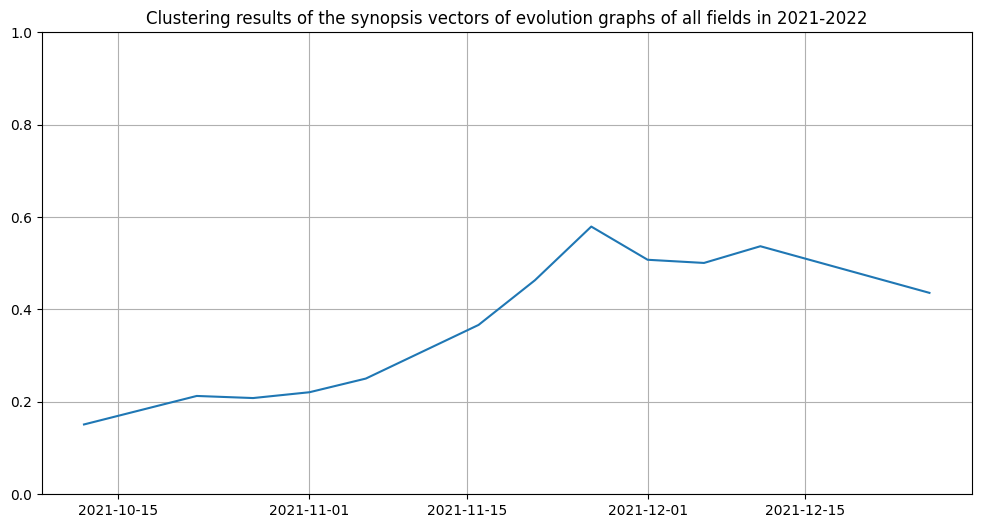

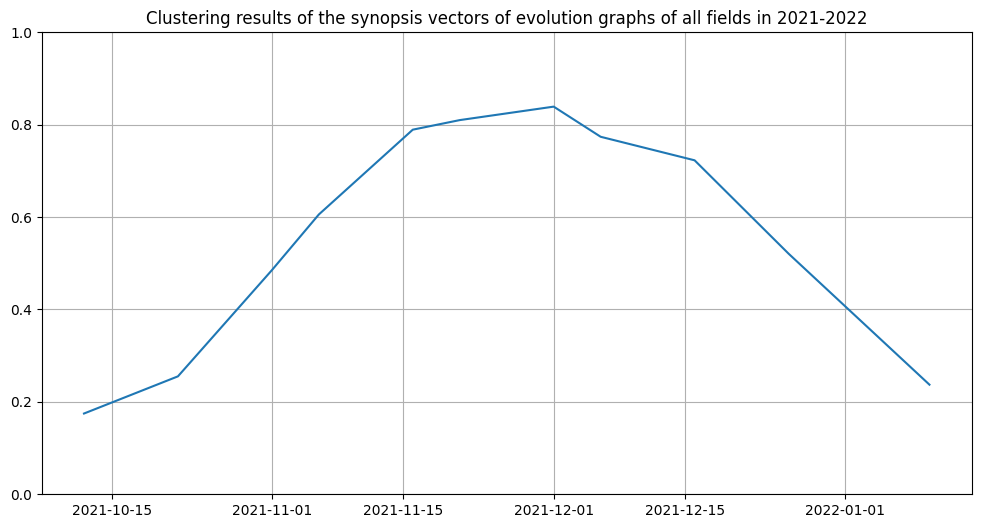

In [18]:
### 2nd part Clustering 
ChangedPixel_List = []
n_synopsis_List= []
for sfd_id_choice in sfd_ids:
    
    n_synopsis = 0
    all_dates = []
    if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan):
        all_dates = [t.dayofyear for x in fld_year_synopsis_df.loc[sfd_id_choice][year_choice] for t in x[0]]
        n_synopsis = len(fld_year_synopsis_df.loc[sfd_id_choice][year_choice])
        n_synopsis_List.append(n_synopsis)
    
    uni_dates = np.unique(all_dates) # used dates of all synopsis of all fields
    
    ### Prepare the data_uniform for clustering
    all_synopsis_list = []
    all_date_list = []
    data_uniform_array = np.ones((n_synopsis, len(uni_dates)))*1000 #16x19

    update = 0
    syn_label = []

    #if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan) and fields_data[fields_data.sfd_id == sfd_id_choice].croptype.values[0] == crop_type:
    if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan):       
        date_list = []
        synopsis_list = []
        bb_ids = []
        # Extracting the information into the date_list/ synopsis_list/ bb_ids
        for x in fld_year_synopsis_df.loc[sfd_id_choice][year_choice]:
            date_list.append(x[0])
            synopsis_list.append(x[1])
            bb_ids.append(str(x[2][0]) + '_' + str(x[2][1]))
        #helper = pd.DataFrame({'date':[pd.to_datetime(uni_dates[i]-1, unit='D', origin=str(year_choice)) for i in range(len(uni_dates))]}) # used dates of all synopsis of all fields
        helper = helps(uni_dates,year_choice)
        #'''
        for i in range(len(date_list)):
            df = pd.DataFrame({'date':date_list[i], 'val':synopsis_list[i]})
            df = pd.merge(df, helper, on='date', how='outer').sort_values('date')
            # Interpolate the missing value in synopsis
            df['val'].interpolate(method='linear', limit_area='inside', inplace=True) 
            #df.interpolate(method='linear', limit_area='inside', inplace=True)
            # Transform into array the synopsis values - shape (16,19)
            data_uniform_array[update] = df['val'].values
            update += 1
        
            syn_label.append(str(sfd_id_choice)+':'+bb_ids[i])
        #'''    
        all_date_list += date_list # Form the storage to keep all information of images
        all_synopsis_list += synopsis_list # Form the storage to keep all information of images 
        
        # Export the graph
        SynopsisGraph(sfd_id_choice,all_synopsis_list,all_date_list,year_choice, save=True)               
        data_uniform_array[data_uniform_array==1000] = np.nan        
        
        if n_synopsis > 2:
            #### Detect the anamoly cluster
            # cluster_discrimination
            method = 'average'
            Z = linkage(data_uniform_array, method=method, metric=dtw_normalized_dist)            
            #Export the graph of each BB
            threshold=5
            AnoClusName,  AnoClusIdx= AnomalyCluster(Z,n_synopsis,threshold,syn_label) 
            plotAnamoly(sfd_id_choice,AnoClusIdx,all_date_list,all_synopsis_list,syn_label,save=True,all_cluster=True)
            
            # Optimization based on Invertia
            threshold = InertiaValueOptimization(sfd_id_choice,data_uniform_array,Z,n_synopsis)
            # Anomaly Cluster Detection
            AnoClusName,  AnoClusIdx= AnomalyCluster(Z,n_synopsis,threshold,syn_label)            
            plotAnamoly(sfd_id_choice,AnoClusIdx,all_date_list,all_synopsis_list,syn_label,save=True)
            # Cummulative the % of the anomaly cluster BB
            percentageOfChangedPixels = AnomalyClusterCumPercentage(sfd_bb_geo_df_sys.loc[sfd_id_choice],AnoClusName,'BB_id','BB_proportion')           
            ChangedPixel_List.append(percentageOfChangedPixels)
        else:
            percentageOfChangedPixels = CummulativeBB_proportion(sfd_bb_geo_df_sys.loc[sfd_id_choice]['BB_proportion'])
            ChangedPixel_List.append(percentageOfChangedPixels)

In [19]:
ChangedPixel_List

[93.11,
 74.16,
 78.38,
 81.28,
 89.9,
 85.62,
 91.49,
 52.879999999999995,
 84.39,
 79.51]

In [20]:
n_synopsis_List

[2, 3, 1, 1, 1, 1, 2, 3, 1, 1]

In [21]:
sfd_bb_geo_df_sys

,BB_id,BB_date,BB_pos_img,BB_seg_id,BB_proportion,EPSG,geometry
sfd_id,,,,,,,
104849953,6_1,20211126,104849953_Bands_20211126_Sentinel2.tif,1,80.09,32721,"MULTIPOLYGON (((-54.21089 -24.73599, -54.21088..."
104849953,6_4,20211126,104849953_Bands_20211126_Sentinel2.tif,4,13.02,32721,"MULTIPOLYGON (((-54.21055 -24.73770, -54.21055..."
104863690,5_3,20211121,104863690_Bands_20211121_Sentinel2.tif,3,44.05,32721,"MULTIPOLYGON (((-54.19099 -24.74212, -54.19098..."
104863690,0_2,20211012,104863690_Bands_20211012_Sentinel2.tif,2,30.11,32721,"MULTIPOLYGON (((-54.19199 -24.74124, -54.19199..."
104863690,0_3,20211012,104863690_Bands_20211012_Sentinel2.tif,3,11.33,32721,"MULTIPOLYGON (((-54.19316 -24.74234, -54.19315..."
104852444,6_3,20211206,104852444_Bands_20211206_Sentinel2.tif,3,78.38,32721,"MULTIPOLYGON (((-54.26351 -24.71549, -54.26351..."
104843446,9_2,20211216,104843446_Bands_20211216_Sentinel2.tif,2,81.28,32721,"MULTIPOLYGON (((-54.20499 -24.69049, -54.20498..."
104844935,7_1,20211201,104844935_Bands_20211201_Sentinel2.tif,1,89.90,32721,"MULTIPOLYGON (((-54.11865 -24.50134, -54.11865..."
104841590,1_2,20211022,104841590_Bands_20211022_Sentinel2.tif,2,85.62,32721,"MULTIPOLYGON (((-54.12451 -24.49531, -54.12451..."


In [325]:
## Add to the DataFrame
data['%ChangedPixel'] = np.nan
data['scale'] = np.nan
data['n_synopsis'] =np.nan
data['%ChangedPixel'][:len(ChangedPixel_List)] = ChangedPixel_List
#data['scale'] = scale_List
data['n_synopsis'][:len(n_synopsis_List)] = n_synopsis_List
### save file 
# file_name =file.split('.')[0]+'_wC_Pixel.csv'
# data.to_csv(dataPath/file_name )
data[['Sfd_id','%ChangedPixel','scale','n_synopsis']]

C:\Users\qle\AppData\Local\Temp\ipykernel_17584\1365029537.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['%ChangedPixel'][:len(ChangedPixel_List)] = ChangedPixel_List
C:\Users\qle\AppData\Local\Temp\ipykernel_17584\1365029537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n_synopsis'][:len(n_synopsis_List)] = n_synopsis_List


,Sfd_id,%ChangedPixel,scale,n_synopsis
0,104839603,81.61,NaN,1.0
1,104851010,78.33,NaN,2.0
2,104851011,52.84,NaN,3.0
3,104856056,81.93,NaN,1.0
4,104856307,82.43,NaN,2.0
5,104838039,85.23,NaN,2.0
6,104856508,38.13,NaN,4.0
7,104852841,93.50,NaN,2.0


## NDVI visualization

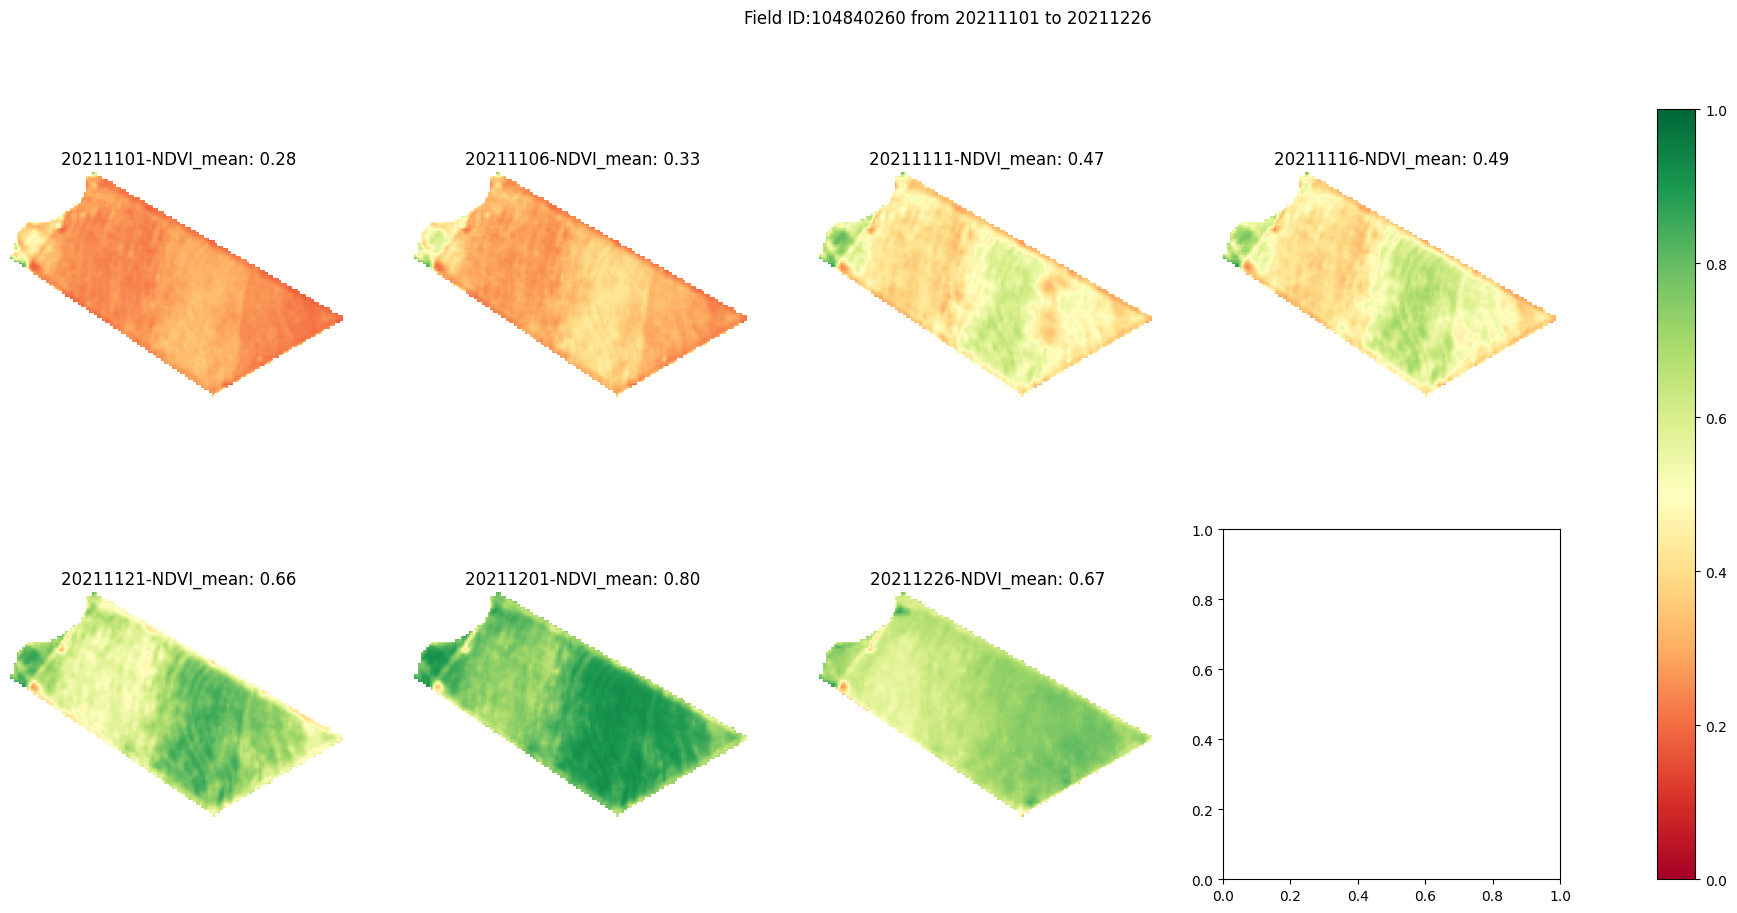

In [157]:
NDVI_numpy, DATE, sfd_id = Generate_NDVI_Image(data_path,ndvi_tif_file,savePath)

## Segmentation visualization

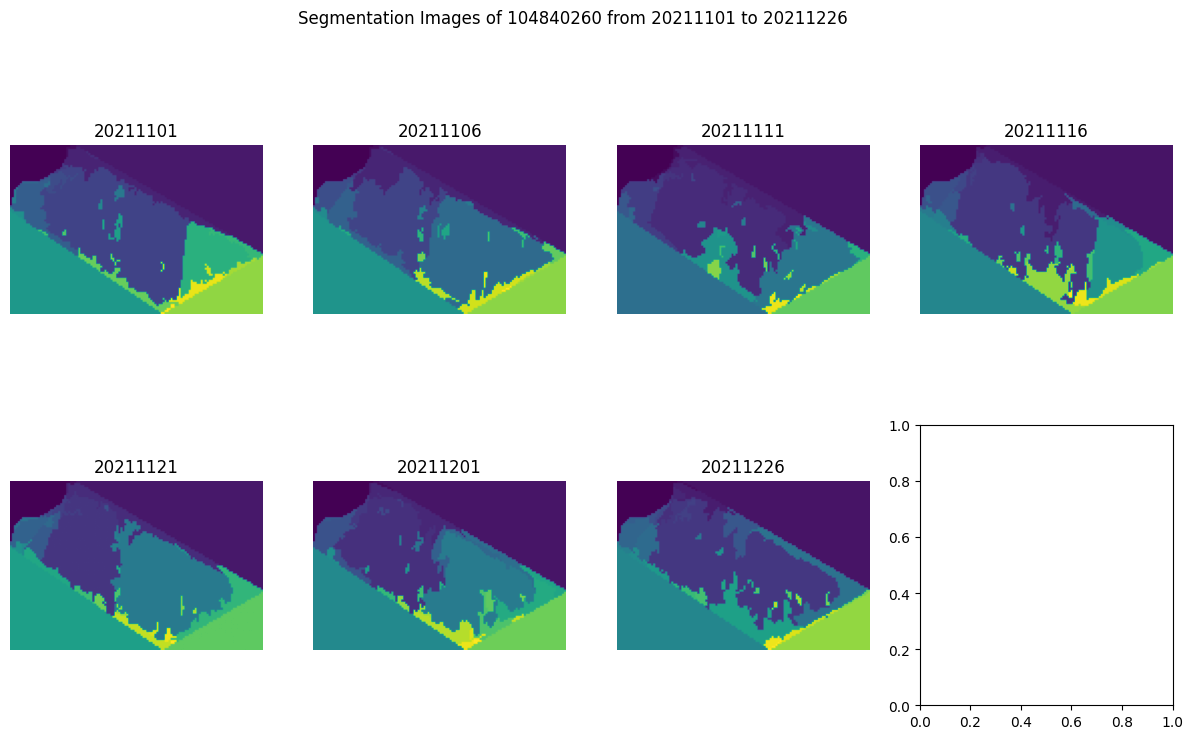

In [158]:
Generate_Segmentation_Image(segments_test,savePath,DATE,sfd_id)

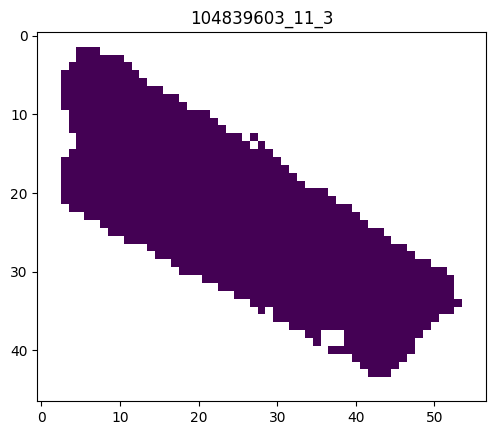

In [26]:
ims(sfd_id_choice,segments_test,11, 3)

C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\matplotlib\_api\__init__.py:127: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if val not in values:


ValueError: array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [4, 4, 4, ..., 6, 6, 6],
       [4, 4, 4, ..., 6, 6, 6],
       [4, 4, 4, ..., 6, 6, 6]], dtype=int64) is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

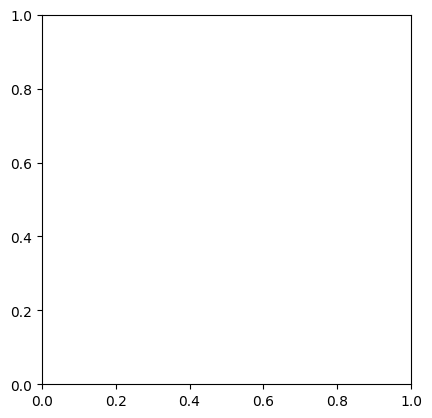

In [25]:
show_image(segments_test[10])

In [15]:
#DisplayingAllPixels(segments_test[10])

# Clustering annotated

## Extract synosis

In [240]:
fld_year_synopsis = []

for sfd_id_choice in sfd_ids:
    #year_choice = fields_data[fields_data.sfd_id == sfd_id_choice].year.unique()[0]
    #raster_df = pd.read_pickle(save_path_df+'{0}_{1}_scale_{2}_raster_seg_df.pkl'.format(sfd_id_choice,year_choice,scale))
    
    dico_year_synopsis = {}
    dico_year_num_bb = {}
    
    segments_test = raster_df['segments_fz']#.iloc[(raster_df.index >= datetime.datetime(year_choice,1,1)) & (raster_df.index <= datetime.datetime(year_choice,12,31))]
    raster_ndvi_numpy_test = raster_df['raster_ndvi_numpy']#.iloc[(raster_df.index >= datetime.datetime(year_choice,1,1)) & (raster_df.index <= datetime.datetime(year_choice,12,31))]

    #bb_final_list = np.load(save_path_bb+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_final_bb.npy'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2), allow_pickle=True)

    ## Evolution graph of each BB given the (fld_id, year)
    dico_year_synopsis[year_choice] = evolution_graph_to_synopsis(sfd_id_choice, year_choice, bb_final_list, segments_test, raster_ndvi_numpy_test, alpha, t1, t2)

    fld_year_synopsis.append(dico_year_synopsis)
    
fld_year_synopsis_df = pd.DataFrame(fld_year_synopsis, index=sfd_ids)

In [241]:
#fld_year_synopsis_df.loc[sfd_id_choice][year_choice]
fld_year_synopsis_df

,2021
104842384,"[([2021-10-22 00:00:00, 2021-10-27 00:00:00, 2..."


## Choose synopsis by (year, croptype) for clustering

In [242]:
all_dates = []

n_synopsis = 0
for sfd_id_choice in sfd_ids:
    if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan):
    #if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan) and fields_data[fields_data.sfd_id == sfd_id_choice].croptype.values[0] == crop_type:
        # Take out the day frim the Timestamp
        all_dates+=[t.dayofyear for x in fld_year_synopsis_df.loc[sfd_id_choice][year_choice] for t in x[0]]
        # The N-of synopsis 
        n_synopsis += len(fld_year_synopsis_df.loc[sfd_id_choice][year_choice])

uni_dates = np.unique(all_dates) # used dates of all synopsis of all fields
n_synopsis

4

In [243]:
#fld_year_synopsis_df.loc[sfd_id_choice][year_choice]

In [244]:
### Prepare the data_uniform for clustering
all_synopsis_list = []
all_date_list = []
data_uniform_array = np.ones((n_synopsis, len(uni_dates)))*1000 #16x19

update = 0
syn_label = []

for sfd_id_choice in sfd_ids:
    #if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan) and fields_data[fields_data.sfd_id == sfd_id_choice].croptype.values[0] == crop_type:
    if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan):
        date_list = []
        synopsis_list = []
        bb_ids = []
        # Extracting the information into the date_list/ synopsis_list/ bb_ids
        for x in fld_year_synopsis_df.loc[sfd_id_choice][year_choice]:
            date_list.append(x[0])
            synopsis_list.append(x[1])
            bb_ids.append(str(x[2][0]) + '_' + str(x[2][1]))
        #helper = pd.DataFrame({'date':[pd.to_datetime(uni_dates[i]-1, unit='D', origin=str(year_choice)) for i in range(len(uni_dates))]}) # used dates of all synopsis of all fields
        helper = helps(uni_dates,year_choice)
        #'''
        for i in range(len(date_list)):
            df = pd.DataFrame({'date':date_list[i], 'val':synopsis_list[i]})
            df = pd.merge(df, helper, on='date', how='outer').sort_values('date')
            # Interpolate the missing value in synopsis
            df['val'].interpolate(method='linear', limit_area='inside', inplace=True) 
            #df.interpolate(method='linear', limit_area='inside', inplace=True)
            # Transform into array the synopsis values - shape (16,19)
            data_uniform_array[update] = df['val'].values
            update += 1
        
            syn_label.append(str(sfd_id_choice)+':'+bb_ids[i])
        #'''    
        all_date_list += date_list # Form the storage to keep all information of images
        all_synopsis_list += synopsis_list # Form the storage to keep all information of images 

# Return the np.nan         
data_uniform_array[data_uniform_array==1000] = np.nan
print(f'n_synopsis size : {n_synopsis}')

clustered_sfd_ids = list(set([el.split(':')[0] for el in syn_label]))
clustered_sfd_ids

n_synopsis size : 4


['104842384']

In [245]:
'''
all_synopsis_list containing the NDVI_weight_mean corressponding to the bounding box 
all_date_list containing the datae 
color --- clustering Ex (1-2-4) - (5-8) - the rest
'''


'\nall_synopsis_list containing the NDVI_weight_mean corressponding to the bounding box \nall_date_list containing the datae \ncolor --- clustering Ex (1-2-4) - (5-8) - the rest\n'

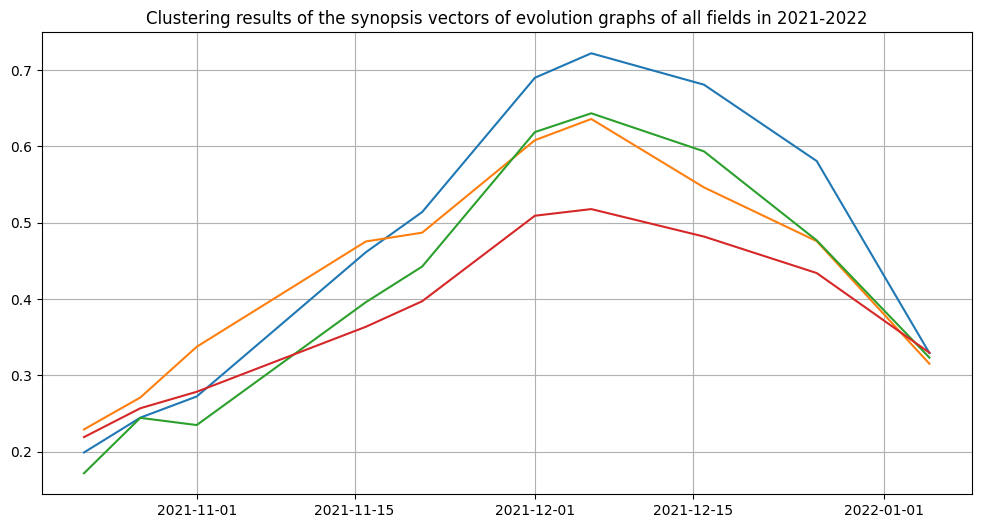

In [246]:
SynopsisGraph(sfd_id_choice,all_synopsis_list,all_date_list,year_choice)

## Agglomerative Hierchical Clustering

In [247]:
# input 16x19 --> output 15x4 (N-1)x4
'''
 At the i-th iteration, clusters n with indices Z[i, 0] and Z[i, 1] are combined to form cluster (n+1).
 A cluster with an index less than n corresponds to one of the n original observations. 
 The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. 
 The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.
'''
method = 'average'
Z = linkage(data_uniform_array, method=method, metric=dtw_normalized_dist)
Z

array([[1.        , 2.        , 0.02425341, 2.        ],
       [3.        , 4.        , 0.03392143, 3.        ],
       [0.        , 5.        , 0.04350738, 4.        ]])

# Display the result

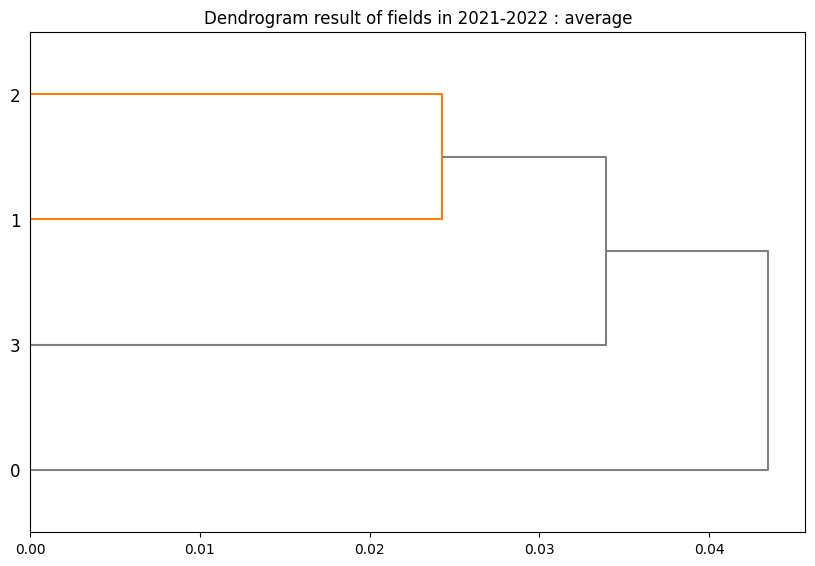

In [248]:
#### Visualizing dendrogram
# set_link_color_palette(None)
plt.close('all')
plt.figure(figsize=(10, 6.5))
d = dendrogram(Z,
               orientation='right', 
               truncate_mode='level', 
               p=n_synopsis, 
               #color_threshold=threshold, 
              above_threshold_color='grey',
                )

#plt.axvline(x=threshold, c='r', lw=2, linestyle='dashed')
#plt.title(f"Dendrogram result of fields with {crop_type} in {year_choice} : {method}, cut level at {threshold}")
plt.title(f"Dendrogram result of fields in {year_choice}-{year_choice+1} : {method}")
plt.show()

# Threshold Optimation

In [249]:
cluster_color = get_cluster_color(d)
cluster_color.keys()
cluster_color.items()

dict_items([('C1', array(['1', '2'], dtype='<U1')), ('grey', array(['0', '3'], dtype='<U1'))])

In [250]:
### Optimal using Inertia value ||value - center||_dtw_normalized_dist
xthreshold = np.arange(0.1,0,-0.005)

intra_std = []
intra_mean = []
inter = []
num_cluster = []
x = []
plt.figure()
for threshold in xthreshold:
    d = dendrogram(Z, orientation='right', truncate_mode='level', p=n_synopsis, color_threshold=threshold, above_threshold_color='grey')

    cluster_color = get_cluster_color(d)
    if len(cluster_color.keys())>50:
        break
    else:
        centers = []
        # inertie intra cluster - among clusters
        intra_k = []
        for idx, (k, v) in enumerate(cluster_color.items()):
            l = [int(i) for i in v] # list the cluster same colors Ex- in grey

            if len(l) != 0:
                center = np.nanmean(data_uniform_array[l, :], axis=0)# calculate all the mean of n_sunpsis of each day
                centers.append(center) # (**,19) aaray - ** depend on the field

                inertie_intra = 0
                for j in l:
                    # Cumulative the normalized distance dtw between center and each date
                    inertie_intra += dtw_normalized_dist(data_uniform_array[j, :], center)**2 
                inertie_intra = inertie_intra/len(l) # average cummulative Normalized between center and each date
            else:
                continue
            intra_k.append(inertie_intra)
    #         print(f'inertie intra cluster : {k} - {inertie_intra}')
    
        intra_std.append(np.nanstd(intra_k))
        intra_mean.append(np.nanmean(intra_k))

        # inertie inter clusters - between clusters
        inertie_inter = 0
        c = np.nanmean(np.array(centers), axis=0)#  
        for center in centers:
            # Cummulative betwwen the Mean of ** abd 
            inertie_inter += dtw_normalized_dist(c, center)**2
            inertie_inter = inertie_inter/len(centers)
        inter.append(inertie_inter)
        num_cluster.append(len(centers))
#     print(f'inertie inter cluster : {inertie_inter}')
        x.append(threshold)
plt.close()

C:\Users\qle\AppData\Local\Temp\ipykernel_17584\2730076217.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  ax2.plot(x, [intra_mean[i]/inter[i] for i in range(len(x))], '--r', label='Ratio intra/inter')


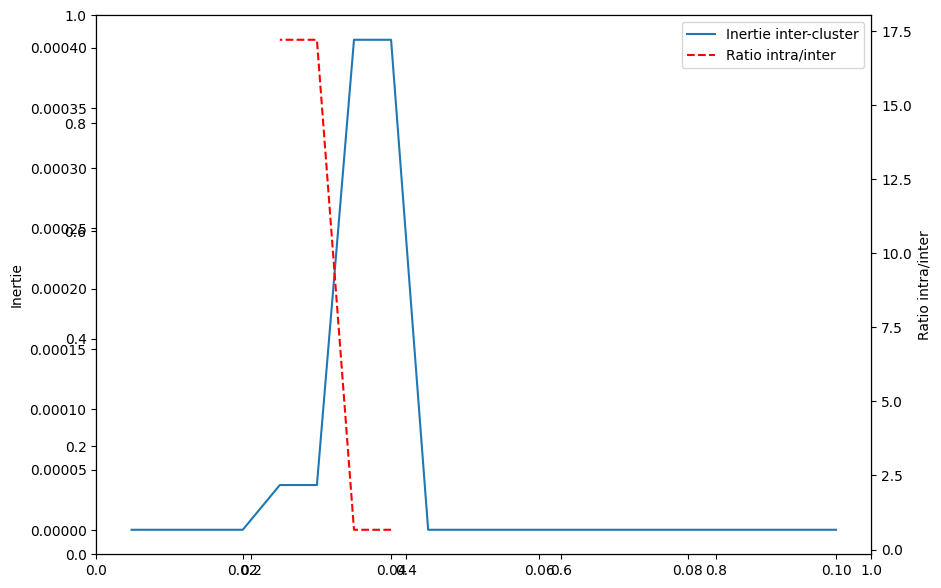

In [251]:
fig = plt.figure(figsize=(10,7))
plt.grid(True)
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
# ax2.plot(x, num_cluster, '--g', label='Nombre de clusters')
# ax2.set_ylabel('Nombre de clusters')

ax1.plot(x, inter, label='Inertie inter-cluster')
ax1.set_ylabel('Inertie')

#ax1.errorbar(x, intra_mean, yerr=intra_std, fmt='--.r', ecolor='grey', elinewidth=2, capsize=2, label='Inertie intra cluster')
#ax1.plot(x, intra_std, '--o', label='Std intra cluster')
ax2.plot(x, [intra_mean[i]/inter[i] for i in range(len(x))], '--r', label='Ratio intra/inter')
ax2.set_ylabel('Ratio intra/inter')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
#plt.axvline(x=0.025, c='b', lw=2, linestyle='dashed')

plt.show()

# Display the result with optimal parameter

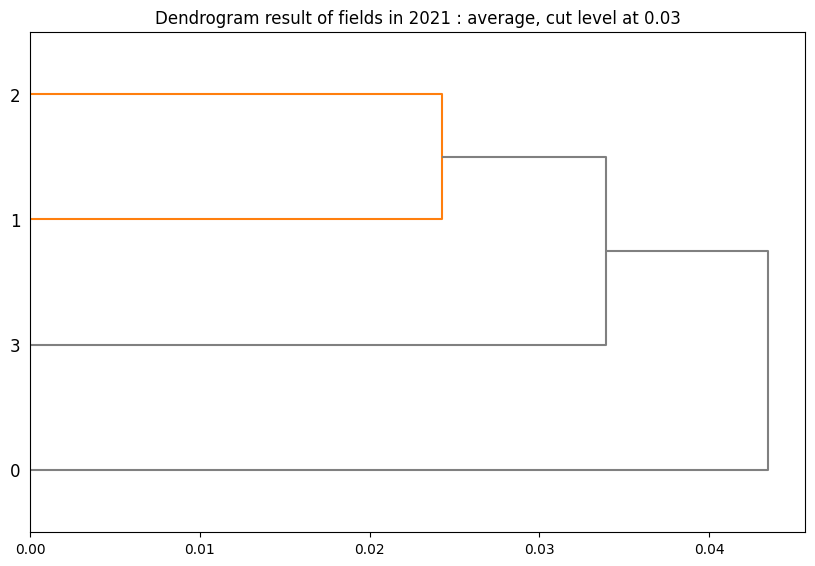

['1', '2']

In [252]:
#### dendrogram
threshold = 0.03
labels = fcluster(Z, t=threshold, criterion='distance')

# set_link_color_palette(None)

plt.figure(figsize=(10, 6.5))
d = dendrogram(Z,
               orientation='right', 
               truncate_mode='level', 
               p=n_synopsis, 
               color_threshold=threshold, 
               above_threshold_color='grey',
                )

#plt.axvline(x=threshold, c='r', lw=2, linestyle='dashed')
#plt.title(f"Dendrogram result of fields with {crop_type} in {year_choice} : {method}, cut level at {threshold}")
plt.title(f"Dendrogram result of fields in {year_choice} : {method}, cut level at {threshold}")
plt.show()

cluster_color = get_cluster_color(d)
label_color = {label:k for k,v in cluster_color.items() for label in v}
len(cluster_color.keys())
cluster_anomaly = {label:k for k,v in cluster_color.items() for label in v if k != 'grey'}
#cluster_anomaly = cluster_color[cluster_color != 'grey']
#print(f"The anomaly cluster are {}")
listAnomaly = list(cluster_anomaly.keys())
listAnomaly

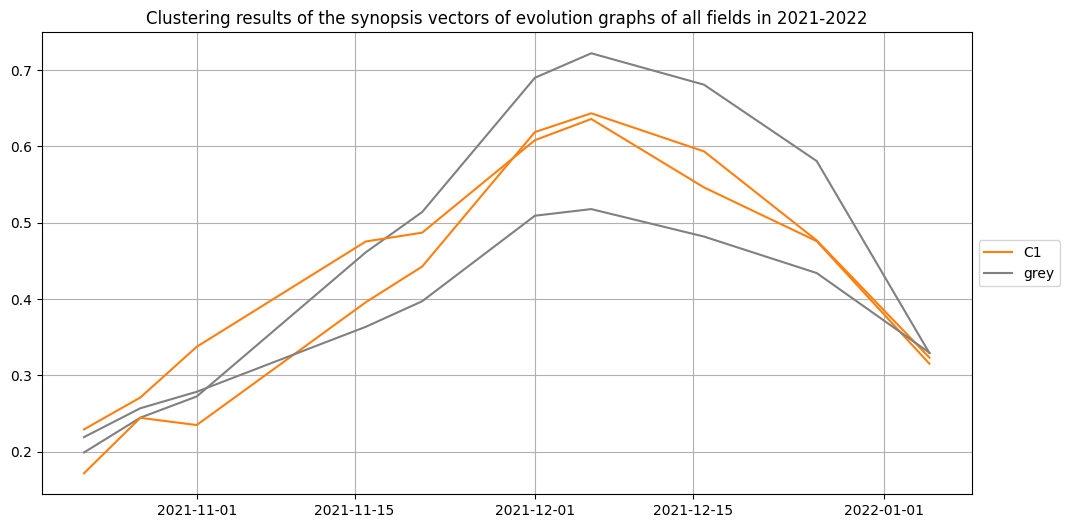

In [253]:
'''
all_synopsis_list containing the NDVI_weight_mean corressponding to the bounding box 
all_date_list containing the datae 
color --- clustering Ex (1-2-4) - (5-8) - the rest
'''
_, ax1 = plt.subplots(figsize=(12,6))
ax1.grid(True)
for i in range(len(all_synopsis_list)):
    ax1.plot(all_date_list[i], all_synopsis_list[i], color=label_color[str(i)])
legend_element = [plt.Line2D([0], [0], color=c, linestyle='-') for c in cluster_color.keys()]
legend_label = [i for i in cluster_color.keys()]
ax1.legend(legend_element, legend_label,loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
# ax1.legend(legend_element, legend_label, bbox_to_anchor=(0.75, 0.7), bbox_transform=plt.gcf().transFigure)
plt.title(f"Clustering results of the synopsis vectors of evolution graphs of all fields in {year_choice}-{year_choice+1}")
plt.show()

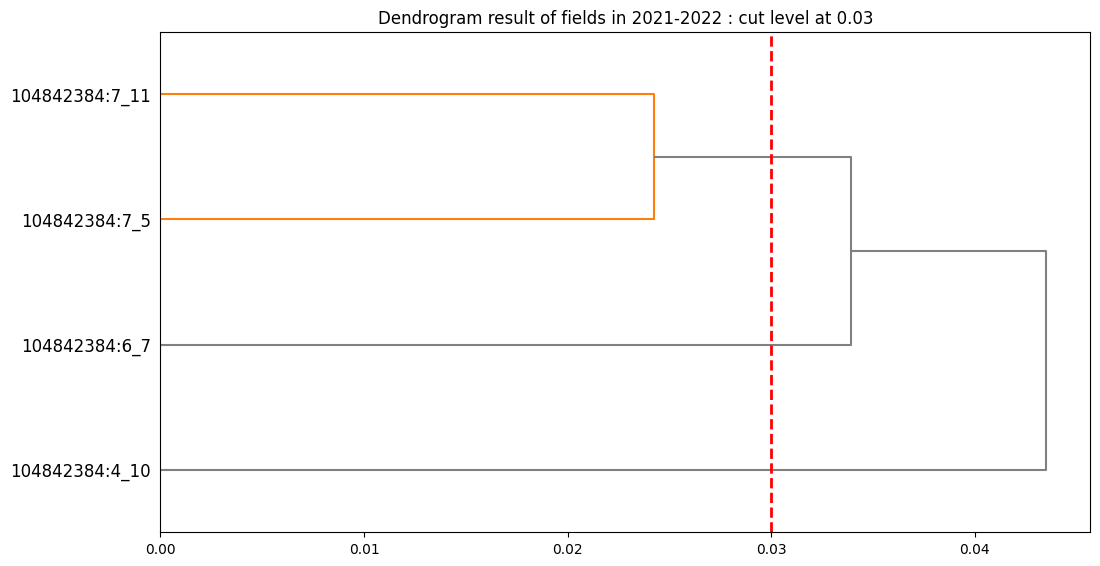

In [254]:
# dendrogram with evolution graph id
fig = plt.figure(figsize=(12, 6.5))
d_id = dendrogram(Z, orientation='right', truncate_mode='level', p=n_synopsis, labels=syn_label, color_threshold=threshold, above_threshold_color='grey')

plt.axvline(x=threshold, c='r', lw=2, linestyle='dashed')
#plt.title(f"Dendrogram result of fields with {crop_type} in {year_choice} : cut level at {threshold}")
plt.title(f"Dendrogram result of fields in {year_choice}-{year_choice+1} : cut level at {threshold}")
plt.show()
cluster_color_id = get_cluster_color(d_id)
label_color_id = {label:k for k,v in cluster_color_id.items() for label in v}

In [175]:
listAnomaly

['0', '1']

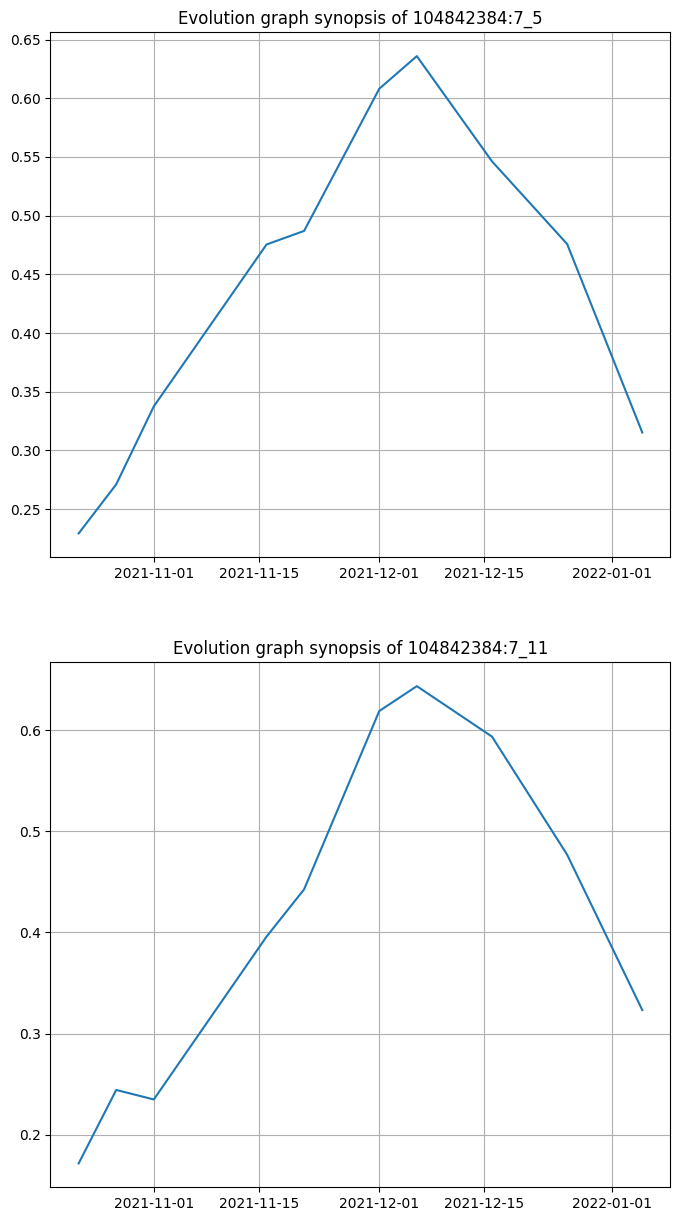

In [255]:
plotAnamoly(sfd_id,listAnomaly,all_date_list,all_synopsis_list,syn_label,show_plot=True)
#listAnomaly

# EVALUTION

## EvolutionGraphEvolution

In [24]:
### Yield the clipping path and Evolution process + Synopsis of the class
def EvolutionGraphEvolution(NDVI_numy,segments_test,Position_image,bouding_box_segment,DATE,sfd_id,all_synopsis_list,syn_label,save=False):
    """
    Plot clipping images coresponding to the position_image and bonding_box_seggment
    """    
    IdxOfBB = [i for i in range(len(syn_label)) if syn_label[i].split(':')[1] == str(Position_image)+'_'+str(bouding_box_segment)][0]
    #print(IdxOfBB)
    # Position_image= 15
    seg_image = segments_test[Position_image] # 68x67
    #bouding_box_segment = 7
    mask =np.zeros(seg_image.shape, dtype=np.uint8)
    mask[seg_image == bouding_box_segment] = 1
    
    # Figure initialization
    NoImage = len(NDVI_numpy)
    ncols = 4      
    NoRows = int(math.ceil(NoImage/ncols)) 
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(17,8) )    
    #print(plt.style.available)
    #plt.style.use("seaborn-v0_8-bright")     
    for idx,test in enumerate(NDVI_numpy):        
        if test.shape != mask.shape:
            #dim = (seg_image.shape[1],seg_image.shape[0])
            #test = cv2.resize(test, dim, interpolation=cv2.INTER_AREA )
            continue
        clipped_image = np.ma.masked_values(cv2.bitwise_and(test, test, mask=mask),0)     
        row,col = idx//ncols, idx%ncols        
        
        a = ax[row][col].imshow(
            clipped_image,
            cmap='RdYlGn',            
            )        
        
        ax[row][col].axis('off') 
        # Set the colorbar scale
        a.set_clim(vmin=0, vmax=1)
        #ax[row][col].set_title(f'{DATE[idx]}-synopsis:{all_synopsis_list[IdxOfBB][idx]:.2f}')
        ax[row][col].set_title(f'{DATE[idx]}') #-synopsis:{all_synopsis_list[IdxOfBB][idx]:.2f}')
             
    fig.colorbar(a, ax=ax[:,:])
    fig.suptitle(f'Evolution Graph of {Position_image}_{bouding_box_segment} of {sfd_id} from {DATE[0]} to {DATE[-1]}')
    plt.show()         
    if save == True: 
        if not os.path.exists(f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}'):
            os.makedirs( f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}')
        fig.savefig(f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}/Images.png ',format='png')  


In [17]:
#EvolutionGraphEvolution(NDVI_numpy, segments_test, 11, 3, DATE,sfd_id,all_synopsis_list,syn_label)

In [492]:
#EvolutionGraphEvolution(NDVI_numpy, segments_test, 11,1, DATE,sfd_id,all_synopsis_list,syn_label)

# VALIDATION

## Ground-truth Change Detection

In [64]:
from rasterio.plot import show
import copy
from osgeo import gdal, gdal_array

In [25]:
def Visualization(raster_ndvi_numpy,segments_fz, seg_label, sfd_id_choice,save=False):
    '''
    Plot 4 figures (Raster, Segmentation, NDVI Images, Anomaly cluster)
    raster_ndvi_numpy: NDVI raster image
    segments_fz: correspondingly segmented image 
    seg_label: anomaly cluster
    sfd_id_choice: field ID
    save: wheher save or not
    '''
    plt.figure(figsize=(15,8))
    plt.subplot(2,2,1)
    plt.imshow(raster_ndvi_numpy)
    plt.title('NDVI raster')

    plt.subplot(2,2,2)
    f1 = plt.imshow(segments_fz)
    plt.colorbar(f1, label='segment label')
    #plt.title(f"({i}) {date_choice} segmentation")
    plt.title(f"Segmentation")

    plt.subplot(2,2,3)
    bb_annotes = copy.deepcopy(raster_ndvi_numpy)
    # bb_annotes.mask += ~(segments_fz == seg_label)
    bb_annotes.mask += ~( (segments_fz == seg_label)+(segments_fz ==17)+(segments_fz ==19) )

    cmap, norm = get_palette(raster_ndvi_numpy)
    f1 = plt.imshow(bb_annotes, cmap=cmap, norm=norm)
    plt.colorbar(f1, label='NDVI')
    plt.title(f"anomaly segment label={seg_label},17,19")

    plt.subplot(2,2,4)
    cmap, norm = get_palette(raster_ndvi_numpy)
    f1 = plt.imshow(raster_ndvi_numpy, cmap=cmap, norm=norm)
    plt.colorbar(f1, label='NDVI')
    #plt.title(f"({i}) {date_choice} NDVI")
    plt.title(f"NDVI")
    #plt.tight_layout()
    #plt.suptitle(f'{sfd_id_choice}_{year_choice}')
    
    plt.suptitle(f'{sfd_id_choice}')
    
    if save == True:
        if not os.path.exists(f'pinnote_anomaly_info/annotations_seg_parameters/{sfd_id_choice}/'):
            os.makedirs(f'pinnote_anomaly_info/annotations_seg_parameters/{sfd_id_choice}/')
        plt.savefig(f'pinnote_anomaly_info/annotations_seg_parameters/{sfd_id_choice}/{sfd_id_choice}_{year_choice}_{date_choice}_scale_{scale}_sigma_{sigma}_minsize_{min_size}.png',
                    format='png')
    
    plt.show()


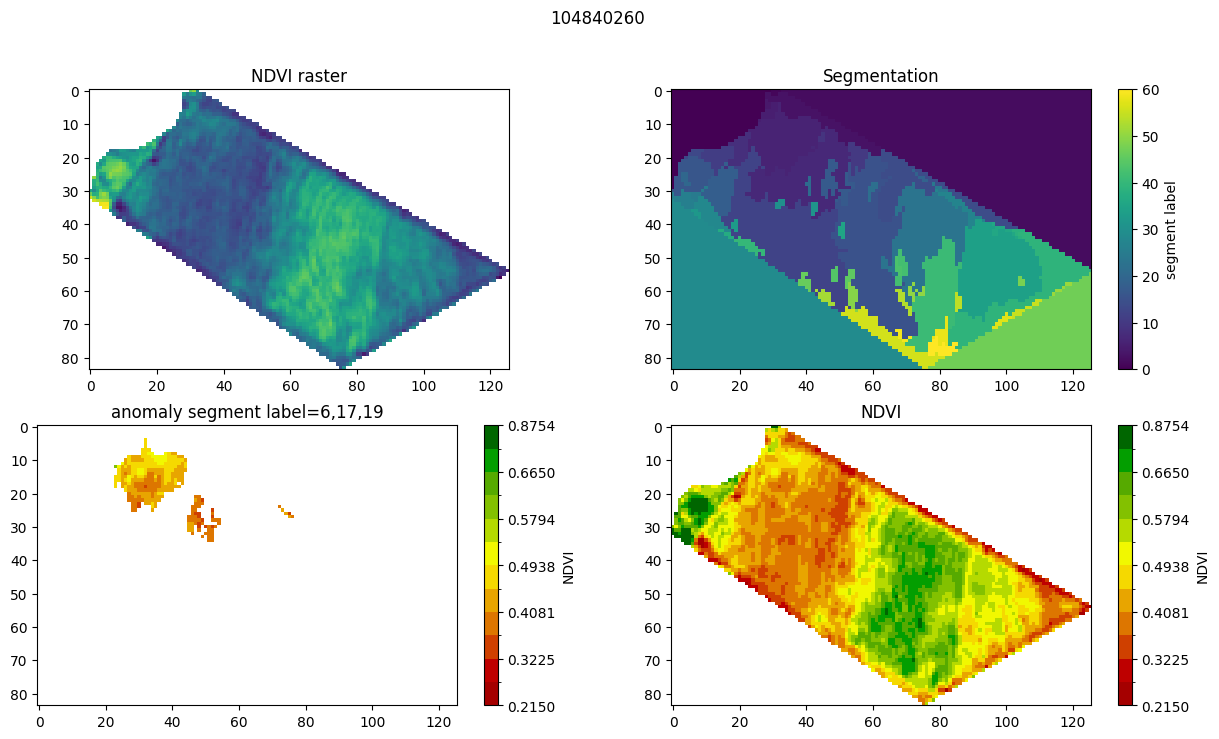

In [214]:
Visualization(raster_ndvi_numpy,segments_fz, seg_label, sfd_id_choice,save=False)

## Generate annomaly binary Image

In [194]:
def open_tiff(path, name):
    ds = gdal.Open(path+"/"+name+".TIF")
    geo = ds.GetGeoTransform()
    proj = ds.GetProjection()
    bands_nb = ds.RasterCount
    W = ds.RasterXSize
    H = ds.RasterYSize
    try:
        image_array = gdal_array.LoadFile(path + "/" + name+".TIF")
    except:
        image_array = gdal_array.LoadFile(path + name+".TIF")
    ds = None
    return np.asarray(image_array), H, W, geo, proj, bands_nb

def create_tiff(nb_channels, new_tiff_name, width, height, datatype, data_array, geotransformation, projection):
    dst_ds = driver_tiff.Create(new_tiff_name, width, height, nb_channels, datatype)
    if nb_channels == 1:
        dst_ds.GetRasterBand(1).WriteArray(data_array)
    else:
        for ch in range(nb_channels):
            dst_ds.GetRasterBand(ch + 1).WriteArray(data_array[ch])
    dst_ds.GetRasterBand(1).SetNoDataValue(-999)
    dst_ds.SetGeoTransform(geotransformation)
    dst_ds.SetProjection(projection)
    return dst_ds

In [195]:
### The anomoly mask (manually)
bi_annotes = np.ma.zeros(raster_ndvi_numpy.shape)
bi_annotes[segments_fz == seg_label] = 1
bi_annotes[segments_fz == 19]= 1
bi_annotes[segments_fz == 17]= 1
bi_annotes[raster_ndvi_numpy.mask] = -999
bi_annotes.mask = copy.deepcopy(raster_ndvi_numpy).mask
bi_annotes

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

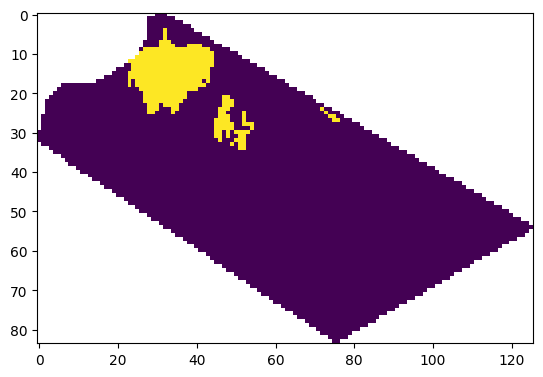

In [196]:
show_image(bi_annotes)

In [187]:
### Save Binary image
driver_tiff = gdal.GetDriverByName("GTiff")
_, H, W, geo, proj, bands_nb = open_tiff(data_path + str(sfd_id_choice), ndvi_tif_file[i].strip('.tif'))

if H != mask_dict[sfd_id_choice].shape[0] or W != mask_dict[sfd_id_choice].shape[1]:
    H, W = mask_dict[sfd_id_choice].shape
    geo = tif_info['transform'].to_gdal()
    save_path = f"variables_2023/annotations/{sfd_id_choice}/"
    
if not os.path.exists(save_path):
    os.makedirs(save_path)
img_name = "variables_2023/annotations/"+str(sfd_id_choice)+"/"+str(sfd_id_choice)+"_"+str(year_choice)+"_"+str(date_choice)+".tif"

ds = create_tiff(1, img_name, W, H, gdal.GDT_Float64, bi_annotes, geo, proj)

##